# Power BI Gateway Log Insights Analysis

This notebook analyzes the enhanced Power BI Gateway logs by joining query start and query execution data, filtered for September 2025.

In [1]:
# === Import Required Libraries ===

import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

print("📚 Libraries imported successfully!")
print(f"🐼 Pandas version: {pd.__version__}")
print(f"📊 NumPy version: {np.__version__}")

📚 Libraries imported successfully!
🐼 Pandas version: 2.3.2
📊 NumPy version: 2.3.3


In [2]:
# === Load Enhanced Query Start Data ===

def load_latest_enhanced_query_start():
    """Load the latest enhanced query start CSV file"""
    
    print("🔍 LOADING ENHANCED QUERY START DATA")
    print("=" * 50)
    
    # Look for enhanced reports directory
    enhanced_reports_dir = "enhanced_reports"
    
    if not os.path.exists(enhanced_reports_dir):
        print(f"❌ Enhanced reports directory not found: {enhanced_reports_dir}")
        return None
    
    # Find the latest query_start_enhanced file
    pattern = os.path.join(enhanced_reports_dir, "query_start_enhanced_*.csv")
    files = glob.glob(pattern)
    
    if not files:
        print(f"❌ No enhanced query start files found in {enhanced_reports_dir}")
        return None
    
    # Get the latest file (by modification time)
    latest_file = max(files, key=os.path.getmtime)
    print(f"📁 Latest file: {os.path.basename(latest_file)}")
    
    # Load the data
    print("📊 Loading data...")
    df = pd.read_csv(latest_file)
    
    print(f"✅ Data loaded successfully!")
    print(f"   📋 Shape: {df.shape}")
    print(f"   📋 Columns: {list(df.columns)}")
    
    return df

# Load the enhanced query start data
query_start_df = load_latest_enhanced_query_start()

🔍 LOADING ENHANCED QUERY START DATA
📁 Latest file: query_start_enhanced_20250924_134017.csv
📊 Loading data...
✅ Data loaded successfully!
   📋 Shape: (24635, 21)
   📋 Columns: ['GatewayObjectId', 'RequestId', 'DataSource', 'QueryTrackingId', 'QueryExecutionStartTimeUTC', 'QueryType', 'SourceFile', 'GatewayFolder', 'LoadTimestamp', 'WorkspaceId', 'DatasetId', 'RootActivityId', 'CurrentActivityId', 'QueryType_TraceIds', 'SKU', 'ApplicationContext', 'AppContext_DatasetId', 'ReportId', 'VisualId', 'ConsumptionMethod', 'UserSession']
✅ Data loaded successfully!
   📋 Shape: (24635, 21)
   📋 Columns: ['GatewayObjectId', 'RequestId', 'DataSource', 'QueryTrackingId', 'QueryExecutionStartTimeUTC', 'QueryType', 'SourceFile', 'GatewayFolder', 'LoadTimestamp', 'WorkspaceId', 'DatasetId', 'RootActivityId', 'CurrentActivityId', 'QueryType_TraceIds', 'SKU', 'ApplicationContext', 'AppContext_DatasetId', 'ReportId', 'VisualId', 'ConsumptionMethod', 'UserSession']


In [6]:
# === Load Query Execution Data ===

def load_query_execution_data():
    """Load the query execution data from processed files"""
    
    print("\n🔍 LOADING QUERY EXECUTION DATA")
    print("=" * 50)
    
    processed_reports_dir = "processed_data"
    # Look for query execution files in current directory
    patterns = [
        "query_execution_combined_*.csv"    
    ]
    
    pattern = os.path.join(processed_reports_dir, "query_execution_combined_*.csv")
    execution_file = glob.glob(pattern)

    if not execution_file:
        print(f"❌ No query execution files found")
        print("   Looking for patterns: query_execution_table_*.csv, QueryExecution_*.csv, *execution*.csv")
        return None

    # Get the latest file
    latest_execution_file = max(execution_file, key=os.path.getmtime)
    print(f"📁 Latest execution file: {os.path.basename(latest_execution_file)}")

    # Load the data
    print("📊 Loading execution data...")
    df = pd.read_csv(latest_execution_file)

    print(f"✅ Execution data loaded successfully!")
    print(f"   📋 Shape: {df.shape}")
    print(f"   📋 Columns: {list(df.columns)}")

    return df



# Load the query execution data
query_execution_df = load_query_execution_data()


🔍 LOADING QUERY EXECUTION DATA
📁 Latest execution file: query_execution_combined_20250924_133704.csv
📊 Loading execution data...
✅ Execution data loaded successfully!
   📋 Shape: (451619, 24)
   📋 Columns: ['GatewayObjectId', 'RequestId', 'QueryTrackingId', 'QueryExecutionEndTimeUTC', 'QueryExecutionDuration(ms)', 'QueryType', 'DataReadingAndSerializationDuration(ms)', 'DataReadingDuration(ms)', 'DataSerializationDuration(ms)', 'SpoolingDiskWritingDuration(ms)', 'SpoolingDiskReadingDuration(ms)', 'SpoolingTotalDataSize(byte)', 'DataProcessingEndTimeUTC', 'DataProcessingDuration(ms)', 'Success', 'ErrorMessage', 'SourceFile', 'GatewayFolder', 'LoadTimestamp', 'DataSource_0', 'DataSource_1', 'DataSource_2', 'DataSource_3', 'DataSource_4']
✅ Execution data loaded successfully!
   📋 Shape: (451619, 24)
   📋 Columns: ['GatewayObjectId', 'RequestId', 'QueryTrackingId', 'QueryExecutionEndTimeUTC', 'QueryExecutionDuration(ms)', 'QueryType', 'DataReadingAndSerializationDuration(ms)', 'DataReadi

In [7]:
# === Check for Duplicate RequestId + QueryTrackingId Combinations ===

def check_duplicate_combinations(df, id_cols=['RequestId', 'QueryTrackingId']):
    """Check if combinations of RequestId and QueryTrackingId are repeating in execution dataframe"""
    
    print("🔍 CHECKING FOR DUPLICATE ID COMBINATIONS")
    print("=" * 60)
    
    if df is None:
        print("❌ Dataframe is None")
        return
    
    print(f"📊 Analyzing dataframe with {len(df):,} rows")
    print(f"🔑 Checking combination of columns: {id_cols}")
    
    # Check if columns exist
    missing_cols = [col for col in id_cols if col not in df.columns]
    if missing_cols:
        print(f"❌ Missing columns: {missing_cols}")
        print(f"📋 Available columns: {list(df.columns)}")
        return
    
    # Check for null values in key columns
    for col in id_cols:
        null_count = df[col].isnull().sum()
        if null_count > 0:
            print(f"⚠️  Column '{col}' has {null_count:,} null values")
    
    # Create combination and check for duplicates
    print(f"\n📈 Analyzing combinations...")
    
    # Drop rows with null values in key columns for accurate analysis
    df_clean = df.dropna(subset=id_cols)
    print(f"📊 After removing null values: {len(df_clean):,} rows")
    
    # Create combination column
    df_clean = df_clean.copy()
    df_clean['combination'] = df_clean[id_cols].apply(lambda x: tuple(x), axis=1)
    
    # Get combination counts
    combination_counts = df_clean['combination'].value_counts()
    
    # Overall statistics
    total_combinations = len(combination_counts)
    unique_combinations = len(combination_counts)
    duplicate_combinations = len(combination_counts[combination_counts > 1])
    total_duplicate_rows = combination_counts[combination_counts > 1].sum() - duplicate_combinations
    
    print(f"\n📊 DUPLICATE ANALYSIS RESULTS:")
    print(f"   📋 Total rows analyzed: {len(df_clean):,}")
    print(f"   🔢 Total unique combinations: {unique_combinations:,}")
    print(f"   🔄 Duplicate combinations: {duplicate_combinations:,}")
    print(f"   📊 Total duplicate rows: {total_duplicate_rows:,}")
    
    if duplicate_combinations > 0:
        print(f"   ⚠️  Duplication rate: {(total_duplicate_rows / len(df_clean)) * 100:.2f}%")
        
        print(f"\n🔍 TOP 10 MOST FREQUENT COMBINATIONS:")
        top_duplicates = combination_counts.head(10)
        for i, (combo, count) in enumerate(top_duplicates.items(), 1):
            if count > 1:
                print(f"   {i:2}. {id_cols[0]}={combo[0]}, {id_cols[1]}={combo[1]} → {count:,} occurrences")
            else:
                break
        
        # Show sample duplicate rows
        most_frequent = combination_counts.index[0]
        sample_duplicates = df_clean[df_clean['combination'] == most_frequent]
        
        if len(sample_duplicates) > 1:
            print(f"\n📋 SAMPLE DUPLICATE ROWS (for most frequent combination):")
            # Show key columns plus a few others for context
            display_cols = id_cols + [col for col in ['QueryExecutionEndTimeUTC', 'QueryType', 'DataSource'] if col in df.columns][:3]
            display(sample_duplicates[display_cols].head())
    else:
        print(f"   ✅ No duplicate combinations found - all combinations are unique!")
    
    return combination_counts

# Check for duplicates in execution dataframe
if 'query_execution_df' in locals() and query_execution_df is not None:
    duplicate_analysis = check_duplicate_combinations(query_execution_df)
else:
    print("❌ Query execution dataframe not available for analysis")

🔍 CHECKING FOR DUPLICATE ID COMBINATIONS
📊 Analyzing dataframe with 451,619 rows
🔑 Checking combination of columns: ['RequestId', 'QueryTrackingId']

📈 Analyzing combinations...
📊 After removing null values: 451,619 rows

📊 DUPLICATE ANALYSIS RESULTS:
   📋 Total rows analyzed: 451,619
   🔢 Total unique combinations: 451,619
   🔄 Duplicate combinations: 0
   📊 Total duplicate rows: 0
   ✅ No duplicate combinations found - all combinations are unique!

📊 DUPLICATE ANALYSIS RESULTS:
   📋 Total rows analyzed: 451,619
   🔢 Total unique combinations: 451,619
   🔄 Duplicate combinations: 0
   📊 Total duplicate rows: 0
   ✅ No duplicate combinations found - all combinations are unique!


In [8]:
# === Join Query Start and Execution Data ===

def join_query_data(start_df, execution_df):
    """Join query start and execution dataframes on RequestId and QueryTrackingId"""
    
    print("\n🔗 JOINING QUERY START AND EXECUTION DATA")
    print("=" * 50)
    
    if start_df is None or execution_df is None:
        print("❌ Cannot join - one or both dataframes are None")
        return None
    
    print(f"📊 Query Start data: {start_df.shape}")
    print(f"📊 Query Execution data: {execution_df.shape}")
    
    # Define join columns
    join_columns = ['RequestId', 'QueryTrackingId']
    
    # Check if join columns exist in both dataframes
    missing_start = [col for col in join_columns if col not in start_df.columns]
    missing_execution = [col for col in join_columns if col not in execution_df.columns]
    
    if missing_start:
        print(f"❌ Missing columns in query start data: {missing_start}")
        print(f"   Available columns: {list(start_df.columns)}")
        return None
        
    if missing_execution:
        print(f"❌ Missing columns in query execution data: {missing_execution}")
        print(f"   Available columns: {list(execution_df.columns)}")
        return None
    
    print(f"🔑 Joining on columns: {join_columns}")
    
    # Check for overlapping combinations
    start_combinations = set(start_df[join_columns].dropna().apply(tuple, axis=1))
    execution_combinations = set(execution_df[join_columns].dropna().apply(tuple, axis=1))
    
    
    common_combinations = start_combinations.intersection(execution_combinations)
    
    print(f"📈 Unique combinations in start data: {len(start_combinations):,}")
    print(f"📈 Unique combinations in execution data: {len(execution_combinations):,}")
    print(f"🔗 Common combinations for joining: {len(common_combinations):,}")
    
    if len(common_combinations) == 0:
        print("❌ No common RequestId + QueryTrackingId combinations found - cannot join data")
        return None
    
    # Perform inner join on both columns
    print("🔗 Performing inner join on RequestId + QueryTrackingId...")
    joined_df = pd.merge(
        start_df, 
        execution_df, 
        on=join_columns, 
        how='inner',
        suffixes=('_start', '_execution')
    )
    
    print(f"✅ Join completed!")
    print(f"   📋 Joined data shape: {joined_df.shape}")
    print(f"   📋 Join success rate: {len(joined_df) / len(start_df) * 100:.1f}% of start records matched")
    print(f"   🎯 Match precision: Using both RequestId and QueryTrackingId ensures accurate pairing")
    
    return joined_df

# Join the data
if query_start_df is not None and query_execution_df is not None:
    joined_df = join_query_data(query_start_df, query_execution_df)
else:
    joined_df = None
    print("❌ Cannot proceed with join - data loading failed")


🔗 JOINING QUERY START AND EXECUTION DATA
📊 Query Start data: (24635, 21)
📊 Query Execution data: (451619, 24)
🔑 Joining on columns: ['RequestId', 'QueryTrackingId']
📈 Unique combinations in start data: 24,635
📈 Unique combinations in execution data: 451,619
🔗 Common combinations for joining: 24,326
🔗 Performing inner join on RequestId + QueryTrackingId...
📈 Unique combinations in start data: 24,635
📈 Unique combinations in execution data: 451,619
🔗 Common combinations for joining: 24,326
🔗 Performing inner join on RequestId + QueryTrackingId...
✅ Join completed!
   📋 Joined data shape: (24326, 43)
   📋 Join success rate: 98.7% of start records matched
   🎯 Match precision: Using both RequestId and QueryTrackingId ensures accurate pairing
✅ Join completed!
   📋 Joined data shape: (24326, 43)
   📋 Join success rate: 98.7% of start records matched
   🎯 Match precision: Using both RequestId and QueryTrackingId ensures accurate pairing


In [9]:
# === Filter Data for September 2025 ===

def filter_september_2025(df):
    """Filter the joined dataframe to keep only September 2025 data"""
    
    print("\n📅 FILTERING FOR SEPTEMBER 2025")
    print("=" * 50)
    
    if df is None:
        print("❌ Cannot filter - dataframe is None")
        return None
    
    print(f"📊 Original data shape: {df.shape}")
    
    # Look for date columns that might contain timestamp information
    date_columns = []
    for col in df.columns:
        if any(keyword in col.lower() for keyword in ['time', 'date', 'timestamp']):
            date_columns.append(col)
    
    print(f"🔍 Found potential date columns: {date_columns}")
    
    # Try to find the main timestamp column (likely from query start)
    primary_date_col = None
    for col in ['QueryExecutionStartTimeUTC', 'QueryExecutionEndTimeUTC', 'Timestamp', 'LoadTimestamp']:
        if col in df.columns:
            primary_date_col = col
            break
    
    if not primary_date_col:
        # Use the first date column found
        if date_columns:
            primary_date_col = date_columns[0]
        else:
            print("❌ No date/timestamp columns found for filtering")
            return df
    
    print(f"📅 Using column for date filtering: {primary_date_col}")
    
    # Convert to datetime
    try:
        df[primary_date_col] = pd.to_datetime(df[primary_date_col], errors='coerce')
        
        # Check date range in data
        min_date = df[primary_date_col].min()
        max_date = df[primary_date_col].max()
        
        print(f"📊 Date range in data: {min_date} to {max_date}")
        
        # Filter for September 2025
        september_2025 = df[
            (df[primary_date_col].dt.year == 2025) & 
            (df[primary_date_col].dt.month == 9)
        ].copy()
        
        print(f"✅ September 2025 filtering completed!")
        print(f"   📋 Filtered data shape: {september_2025.shape}")
        print(f"   📊 Records kept: {len(september_2025):,} out of {len(df):,} ({len(september_2025)/len(df)*100:.1f}%)")
        
        if len(september_2025) > 0:
            # Show date range in filtered data
            filtered_min = september_2025[primary_date_col].min()
            filtered_max = september_2025[primary_date_col].max()
            print(f"   📅 Filtered date range: {filtered_min} to {filtered_max}")
        
        return september_2025
        
    except Exception as e:
        print(f"❌ Error filtering dates: {str(e)}")
        return df

# Filter for September 2025
if joined_df is not None:
    september_df = filter_september_2025(joined_df)
    
    if september_df is not None and len(september_df) > 0:
        print(f"\n🎉 SUCCESS! September 2025 data ready for analysis")
        print(f"   📊 Final dataset shape: {september_df.shape}")
    else:
        print(f"\n⚠️  No data found for September 2025")
else:
    september_df = None
    print("❌ Cannot filter - no joined data available")


📅 FILTERING FOR SEPTEMBER 2025
📊 Original data shape: (24326, 43)
🔍 Found potential date columns: ['QueryExecutionStartTimeUTC', 'LoadTimestamp_start', 'QueryExecutionEndTimeUTC', 'DataProcessingEndTimeUTC', 'LoadTimestamp_execution']
📅 Using column for date filtering: QueryExecutionStartTimeUTC
📊 Date range in data: 2025-09-03 14:19:20.986805100+00:00 to 2025-09-15 14:56:52.176885200+00:00
✅ September 2025 filtering completed!
   📋 Filtered data shape: (24326, 43)
   📊 Records kept: 24,326 out of 24,326 (100.0%)
   📅 Filtered date range: 2025-09-03 14:19:20.986805100+00:00 to 2025-09-15 14:56:52.176885200+00:00

🎉 SUCCESS! September 2025 data ready for analysis
   📊 Final dataset shape: (24326, 43)


In [14]:
september_df

,GatewayObjectId_start,RequestId,DataSource,QueryTrackingId,QueryExecutionStartTimeUTC,QueryType_start,SourceFile_start,GatewayFolder_start,LoadTimestamp_start,WorkspaceId,...,Success,ErrorMessage,SourceFile_execution,GatewayFolder_execution,LoadTimestamp_execution,DataSource_0,DataSource_1,DataSource_2,DataSource_3,DataSource_4
0,418b9fbd-21fe-4de2-ba0d-35a5968cf820,1464586c-781c-4833-9384-01761153d564,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",0f9d722b-54d1-4bf6-8e42-8d9dcbb6bc2a,2025-09-04 16:48:08.737182600+00:00,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,N,DataReadingAndSerialization failed with error:...,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""EDW-PRD;DataHub""}",NaN,NaN,NaN,NaN
1,418b9fbd-21fe-4de2-ba0d-35a5968cf820,f56bf6c3-331b-4d70-89da-1b8955aa95a8,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",26a22a06-08a1-4acf-8ea1-04f8addc1f36,2025-09-04 16:48:08.742182500+00:00,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""EDW-PRD;DataHub""}",NaN,NaN,NaN,NaN
2,418b9fbd-21fe-4de2-ba0d-35a5968cf820,0e5147f6-9aa6-4962-bf12-347ba9544033,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",42b1f32b-2996-44c7-bf16-35abde4559a5,2025-09-04 16:48:08.767186200+00:00,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""EDW-PRD;DataHub""}",NaN,NaN,NaN,NaN
3,418b9fbd-21fe-4de2-ba0d-35a5968cf820,f5c3fca4-90f5-437d-8008-b046d2818d5a,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",1f6be601-8b5e-40bd-93b5-c317c693a628,2025-09-04 16:48:08.907181900+00:00,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""EDW-PRD;DataHub""}",NaN,NaN,NaN,NaN
4,418b9fbd-21fe-4de2-ba0d-35a5968cf820,f5c3fca4-90f5-437d-8008-b046d2818d5a,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",36097006-ee60-4429-b3d7-22383920c295,2025-09-04 16:48:08.937183+00:00,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""EDW-PRD;DataHub""}",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24321,d58b530e-cec5-4620-a141-bfbc9c861992,a3bf5507-5ad5-420f-977c-e185d80bbd12,"[""{\""kind\"":\""SQL\"",\""path\"":\""edw-prd;DataHub...",83cf363f-1e1f-4655-b71c-638c726ec23e,2025-09-15 13:38:48.110925100+00:00,Refresh,QueryStartReport_MDC-AZRDTGW-P02_20250903T0919...,Gateway2,2025-09-24 13:35:23.379923,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P02_20240904T...,Gateway2,2025-09-24 13:35:21.697571,"{""kind"":""SQL"",""path"":""edw-prd;DataHub""}",NaN,NaN,NaN,NaN
24322,d58b530e-cec5-4620-a141-bfbc9c861992,940ac9dd-42fe-40a6-8608-cb2bfaa0040a,"[""{\""kind\"":\""SQL\"",\""path\"":\""edw-prd;DataHub...",581f5aa9-3f63-407b-a73c-dde24cba7153,2025-09-15 13:40:54.256881800+00:00,Refresh,QueryStartReport_MDC-AZRDTGW-P02_20250903T0919...,Gateway2,2025-09-24 13:35:23.379923,FBD4E667-B129-4B58-97F0-1BC992E5FA23,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P02_20240904T...,Gateway2,2025-09-24 13:35:21.697571,"{""kind"":""SQL"",""path"":""edw-prd;DataHub""}",NaN,NaN,NaN,

In [10]:
# === Data Summary and Preview ===

def display_data_summary(df, df_name):
    """Display comprehensive summary of the dataframe"""
    
    print(f"\n📊 {df_name.upper()} SUMMARY")
    print("=" * 50)
    
    if df is None:
        print("❌ Dataframe is None")
        return
    
    if len(df) == 0:
        print("⚠️  Dataframe is empty")
        return
    
    print(f"📋 Shape: {df.shape}")
    print(f"📋 Columns ({len(df.columns)}): {', '.join(df.columns)}")
    
    # Show key enhanced columns if available
    key_columns = ['WorkspaceId', 'DatasetId', 'QueryType_TraceIds', 'SKU', 'ReportId']
    available_key_cols = [col for col in key_columns if col in df.columns]
    
    if available_key_cols:
        print(f"\n✅ Key Enhanced Columns Available:")
        for col in available_key_cols:
            non_null = df[col].notna().sum()
            unique = df[col].nunique()
            coverage = (non_null / len(df)) * 100
            print(f"   📈 {col}: {non_null:,} values ({coverage:.1f}% coverage, {unique} unique)")
    
    # Show sample data
    print(f"\n📄 Sample Data (first 3 rows):")
    display(df.head(3))

# Display summaries of all dataframes
if query_start_df is not None:
    display_data_summary(query_start_df, "Query Start Enhanced")

if query_execution_df is not None:
    display_data_summary(query_execution_df, "Query Execution")

if joined_df is not None:
    display_data_summary(joined_df, "Joined Data")

if 'september_df' in locals() and september_df is not None:
    display_data_summary(september_df, "September 2025 Filtered Data")


📊 QUERY START ENHANCED SUMMARY
📋 Shape: (24635, 21)
📋 Columns (21): GatewayObjectId, RequestId, DataSource, QueryTrackingId, QueryExecutionStartTimeUTC, QueryType, SourceFile, GatewayFolder, LoadTimestamp, WorkspaceId, DatasetId, RootActivityId, CurrentActivityId, QueryType_TraceIds, SKU, ApplicationContext, AppContext_DatasetId, ReportId, VisualId, ConsumptionMethod, UserSession

✅ Key Enhanced Columns Available:
   📈 WorkspaceId: 23,854 values (96.8% coverage, 34 unique)
   📈 DatasetId: 23,854 values (96.8% coverage, 400 unique)
   📈 QueryType_TraceIds: 23,854 values (96.8% coverage, 2 unique)
   📈 SKU: 23,854 values (96.8% coverage, 2 unique)
   📈 ReportId: 4,665 values (18.9% coverage, 33 unique)

📄 Sample Data (first 3 rows):


,GatewayObjectId,RequestId,DataSource,QueryTrackingId,QueryExecutionStartTimeUTC,QueryType,SourceFile,GatewayFolder,LoadTimestamp,WorkspaceId,...,RootActivityId,CurrentActivityId,QueryType_TraceIds,SKU,ApplicationContext,AppContext_DatasetId,ReportId,VisualId,ConsumptionMethod,UserSession
0,418b9fbd-21fe-4de2-ba0d-35a5968cf820,1464586c-781c-4833-9384-01761153d564,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",0f9d722b-54d1-4bf6-8e42-8d9dcbb6bc2a,2025-09-04T16:48:08.7371826Z,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,1464586c-781c-4833-9384-01761153d564,a8a133a8-467c-428a-abda-1eecfef7ad50,DirectQuery,Premium,"{""DatasetId"":""c097b83d-16a9-4fc1-afee-be009149...",c097b83d-16a9-4fc1-afee-be00914926ae,23f4bdec-7285-43a9-a7a5-916860bcbd2a,eb39794303e2d9aa39ab,Power BI Web App,a0ba8b5e-c7f0-4bc6-ba0a-8cc048bd3bd9
1,418b9fbd-21fe-4de2-ba0d-35a5968cf820,f56bf6c3-331b-4d70-89da-1b8955aa95a8,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",26a22a06-08a1-4acf-8ea1-04f8addc1f36,2025-09-04T16:48:08.7421825Z,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,f56bf6c3-331b-4d70-89da-1b8955aa95a8,9946f706-22bc-4f76-80ac-3e1c0fb64dc6,DirectQuery,Premium,"{""DatasetId"":""c097b83d-16a9-4fc1-afee-be009149...",c097b83d-16a9-4fc1-afee-be00914926ae,23f4bdec-7285-43a9-a7a5-916860bcbd2a,ef960bf1e53651534481,Power BI Web App,a0ba8b5e-c7f0-4bc6-ba0a-8cc048bd3bd9
2,418b9fbd-21fe-4de2-ba0d-35a5968cf820,0e5147f6-9aa6-4962-bf12-347ba9544033,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",42b1f32b-2996-44c7-bf16-35abde4559a5,2025-09-04T16:48:08.7671862Z,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,0e5147f6-9aa6-4962-bf12-347ba9544033,e3003014-9493-41ca-b2fd-6561113e59dc,DirectQuery,Premium,"{""DatasetId"":""c097b83d-16a9-4fc1-afee-be009149...",c097b83d-16a9-4fc1-afee-be00914926ae,23f4bdec-7285-43a9-a7a5-916860bcbd2a,c9bd1d33ba33d320e8c3,Power BI Web App,a0ba8b5e-c7f0-4bc6-ba0a-8cc048bd3bd9



📊 QUERY EXECUTION SUMMARY
📋 Shape: (451619, 24)
📋 Columns (24): GatewayObjectId, RequestId, QueryTrackingId, QueryExecutionEndTimeUTC, QueryExecutionDuration(ms), QueryType, DataReadingAndSerializationDuration(ms), DataReadingDuration(ms), DataSerializationDuration(ms), SpoolingDiskWritingDuration(ms), SpoolingDiskReadingDuration(ms), SpoolingTotalDataSize(byte), DataProcessingEndTimeUTC, DataProcessingDuration(ms), Success, ErrorMessage, SourceFile, GatewayFolder, LoadTimestamp, DataSource_0, DataSource_1, DataSource_2, DataSource_3, DataSource_4

📄 Sample Data (first 3 rows):


,GatewayObjectId,RequestId,QueryTrackingId,QueryExecutionEndTimeUTC,QueryExecutionDuration(ms),QueryType,DataReadingAndSerializationDuration(ms),DataReadingDuration(ms),DataSerializationDuration(ms),SpoolingDiskWritingDuration(ms),...,Success,ErrorMessage,SourceFile,GatewayFolder,LoadTimestamp,DataSource_0,DataSource_1,DataSource_2,DataSource_3,DataSource_4
0,418b9fbd-21fe-4de2-ba0d-35a5968cf820,4a8aa426-36d7-4354-9c50-15a224a97b2b,dd96995c-d21f-4ca1-9924-673dc25b3922,2025-03-25T19:35:29.0935009Z,2464,Refresh,797.0,467.0,186.0,39.0,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""edw-prd;Analytics""}",NaN,NaN,NaN,NaN
1,418b9fbd-21fe-4de2-ba0d-35a5968cf820,4a8aa426-36d7-4354-9c50-15a224a97b2b,3a91658e-dfb0-4635-bd15-c7b7295e8864,2025-03-25T19:35:32.6636390Z,17,Refresh,14.0,0.0,0.0,7.0,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""edw-prd;Analytics""}",NaN,NaN,NaN,NaN
2,418b9fbd-21fe-4de2-ba0d-35a5968cf820,d53ea6a1-fee8-4cfe-83f9-66fffb7ac477,ca015924-4bb9-4543-b156-99583f73dd1a,2025-03-25T19:36:25.3918265Z,620,Refresh,54961.0,34014.0,18652.0,1420.0,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""edw-prd;BIA""}",NaN,NaN,NaN,NaN



📊 JOINED DATA SUMMARY
📋 Shape: (24326, 43)
📋 Columns (43): GatewayObjectId_start, RequestId, DataSource, QueryTrackingId, QueryExecutionStartTimeUTC, QueryType_start, SourceFile_start, GatewayFolder_start, LoadTimestamp_start, WorkspaceId, DatasetId, RootActivityId, CurrentActivityId, QueryType_TraceIds, SKU, ApplicationContext, AppContext_DatasetId, ReportId, VisualId, ConsumptionMethod, UserSession, GatewayObjectId_execution, QueryExecutionEndTimeUTC, QueryExecutionDuration(ms), QueryType_execution, DataReadingAndSerializationDuration(ms), DataReadingDuration(ms), DataSerializationDuration(ms), SpoolingDiskWritingDuration(ms), SpoolingDiskReadingDuration(ms), SpoolingTotalDataSize(byte), DataProcessingEndTimeUTC, DataProcessingDuration(ms), Success, ErrorMessage, SourceFile_execution, GatewayFolder_execution, LoadTimestamp_execution, DataSource_0, DataSource_1, DataSource_2, DataSource_3, DataSource_4

✅ Key Enhanced Columns Available:
   📈 WorkspaceId: 23,545 values (96.8% coverage

,GatewayObjectId_start,RequestId,DataSource,QueryTrackingId,QueryExecutionStartTimeUTC,QueryType_start,SourceFile_start,GatewayFolder_start,LoadTimestamp_start,WorkspaceId,...,Success,ErrorMessage,SourceFile_execution,GatewayFolder_execution,LoadTimestamp_execution,DataSource_0,DataSource_1,DataSource_2,DataSource_3,DataSource_4
0,418b9fbd-21fe-4de2-ba0d-35a5968cf820,1464586c-781c-4833-9384-01761153d564,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",0f9d722b-54d1-4bf6-8e42-8d9dcbb6bc2a,2025-09-04 16:48:08.737182600+00:00,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,N,DataReadingAndSerialization failed with error:...,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""EDW-PRD;DataHub""}",NaN,NaN,NaN,NaN
1,418b9fbd-21fe-4de2-ba0d-35a5968cf820,f56bf6c3-331b-4d70-89da-1b8955aa95a8,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",26a22a06-08a1-4acf-8ea1-04f8addc1f36,2025-09-04 16:48:08.742182500+00:00,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""EDW-PRD;DataHub""}",NaN,NaN,NaN,NaN
2,418b9fbd-21fe-4de2-ba0d-35a5968cf820,0e5147f6-9aa6-4962-bf12-347ba9544033,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",42b1f32b-2996-44c7-bf16-35abde4559a5,2025-09-04 16:48:08.767186200+00:00,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""EDW-PRD;DataHub""}",NaN,NaN,NaN,NaN



📊 SEPTEMBER 2025 FILTERED DATA SUMMARY
📋 Shape: (24326, 43)
📋 Columns (43): GatewayObjectId_start, RequestId, DataSource, QueryTrackingId, QueryExecutionStartTimeUTC, QueryType_start, SourceFile_start, GatewayFolder_start, LoadTimestamp_start, WorkspaceId, DatasetId, RootActivityId, CurrentActivityId, QueryType_TraceIds, SKU, ApplicationContext, AppContext_DatasetId, ReportId, VisualId, ConsumptionMethod, UserSession, GatewayObjectId_execution, QueryExecutionEndTimeUTC, QueryExecutionDuration(ms), QueryType_execution, DataReadingAndSerializationDuration(ms), DataReadingDuration(ms), DataSerializationDuration(ms), SpoolingDiskWritingDuration(ms), SpoolingDiskReadingDuration(ms), SpoolingTotalDataSize(byte), DataProcessingEndTimeUTC, DataProcessingDuration(ms), Success, ErrorMessage, SourceFile_execution, GatewayFolder_execution, LoadTimestamp_execution, DataSource_0, DataSource_1, DataSource_2, DataSource_3, DataSource_4

✅ Key Enhanced Columns Available:
   📈 WorkspaceId: 23,545 value

,GatewayObjectId_start,RequestId,DataSource,QueryTrackingId,QueryExecutionStartTimeUTC,QueryType_start,SourceFile_start,GatewayFolder_start,LoadTimestamp_start,WorkspaceId,...,Success,ErrorMessage,SourceFile_execution,GatewayFolder_execution,LoadTimestamp_execution,DataSource_0,DataSource_1,DataSource_2,DataSource_3,DataSource_4
0,418b9fbd-21fe-4de2-ba0d-35a5968cf820,1464586c-781c-4833-9384-01761153d564,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",0f9d722b-54d1-4bf6-8e42-8d9dcbb6bc2a,2025-09-04 16:48:08.737182600+00:00,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,N,DataReadingAndSerialization failed with error:...,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""EDW-PRD;DataHub""}",NaN,NaN,NaN,NaN
1,418b9fbd-21fe-4de2-ba0d-35a5968cf820,f56bf6c3-331b-4d70-89da-1b8955aa95a8,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",26a22a06-08a1-4acf-8ea1-04f8addc1f36,2025-09-04 16:48:08.742182500+00:00,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""EDW-PRD;DataHub""}",NaN,NaN,NaN,NaN
2,418b9fbd-21fe-4de2-ba0d-35a5968cf820,0e5147f6-9aa6-4962-bf12-347ba9544033,"[""{\""kind\"":\""SQL\"",\""path\"":\""EDW-PRD;DataHub...",42b1f32b-2996-44c7-bf16-35abde4559a5,2025-09-04 16:48:08.767186200+00:00,DirectQuery,QueryStartReport_MDC-AZRDTGW-P01_20250904T1148...,Gateway1,2025-09-24 13:35:22.481503,A65A34D1-846F-42F4-BC7A-1654C7926D9B,...,Y,NaN,QueryExecutionReport_MDC-AZRDTGW-P01_20250325T...,Gateway1,2025-09-24 13:35:20.628119,"{""kind"":""SQL"",""path"":""EDW-PRD;DataHub""}",NaN,NaN,NaN,NaN


In [15]:
# === Top 20 Queries Analysis by Duration and Spool Usage ===

def analyze_top_queries_by_performance(df):
    """Analyze top 20 queries by duration and spool usage with dataset/workspace info"""
    
    print("🔍 TOP 20 QUERIES ANALYSIS BY PERFORMANCE")
    print("=" * 60)
    
    if df is None or len(df) == 0:
        print("❌ No data available for analysis")
        return None
    
    print(f"📊 Analyzing {len(df):,} query records from September 2025")
    
    # Define performance metrics
    duration_col = 'ExecutionDuration_Seconds'
    spool_cols = ['SpoolingDiskWritingDuration', 'SpoolingDiskReadingDuration', 'SpoolingTotalDataSize']
    
    # Check if required columns exist
    required_cols = ['RequestId', 'QueryTrackingId']
    available_cols = [col for col in required_cols if col in df.columns]
    
    if len(available_cols) < 2:
        print(f"❌ Missing required columns. Available: {available_cols}")
        return None
    
    # Check performance metrics columns
    if duration_col not in df.columns:
        print(f"❌ Duration column '{duration_col}' not found")
        duration_col = None
        for col in df.columns:
            if 'duration' in col.lower() or 'time' in col.lower():
                duration_col = col
                print(f"✅ Using alternative duration column: {duration_col}")
                break
    
    # Calculate total spool usage
    df_analysis = df.copy()
    spool_available = [col for col in spool_cols if col in df.columns]
    
    if spool_available:
        print(f"✅ Spool columns available: {spool_available}")
        # Convert spool columns to numeric
        for col in spool_available:
            df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
        
        # Calculate total spool usage (combine writing, reading, and data size)
        df_analysis['TotalSpoolUsage'] = 0
        if 'SpoolingDiskWritingDuration' in spool_available:
            df_analysis['TotalSpoolUsage'] += df_analysis['SpoolingDiskWritingDuration'].fillna(0)
        if 'SpoolingDiskReadingDuration' in spool_available:
            df_analysis['TotalSpoolUsage'] += df_analysis['SpoolingDiskReadingDuration'].fillna(0)
        if 'SpoolingTotalDataSize' in spool_available:
            # Scale data size to be comparable with duration (convert bytes to MB and scale)
            df_analysis['TotalSpoolUsage'] += (df_analysis['SpoolingTotalDataSize'].fillna(0) / (1024*1024)) * 0.1
    else:
        df_analysis['TotalSpoolUsage'] = 0
        print("⚠️  No spool usage columns found")
    
    # Convert duration to numeric
    if duration_col:
        df_analysis[duration_col] = pd.to_numeric(df_analysis[duration_col], errors='coerce')
    
    # Create composite performance score
    duration_weight = 0.6
    spool_weight = 0.4
    
    if duration_col:
        duration_normalized = (df_analysis[duration_col] - df_analysis[duration_col].min()) / (df_analysis[duration_col].max() - df_analysis[duration_col].min())
    else:
        duration_normalized = 0
        
    spool_normalized = (df_analysis['TotalSpoolUsage'] - df_analysis['TotalSpoolUsage'].min()) / (df_analysis['TotalSpoolUsage'].max() - df_analysis['TotalSpoolUsage'].min())
    
    df_analysis['PerformanceScore'] = (duration_weight * duration_normalized.fillna(0)) + (spool_weight * spool_normalized.fillna(0))
    
    # Select columns for analysis
    analysis_cols = ['RequestId', 'QueryTrackingId']
    
    # Add dataset and workspace columns if available
    id_cols = ['WorkspaceId', 'DatasetId', 'ReportId']
    available_id_cols = [col for col in id_cols if col in df.columns]
    analysis_cols.extend(available_id_cols)
    
    # Add performance columns
    perf_cols = []
    if duration_col:
        perf_cols.append(duration_col)
        analysis_cols.append(duration_col)
    
    for col in spool_available:
        analysis_cols.append(col)
    
    analysis_cols.extend(['TotalSpoolUsage', 'PerformanceScore'])
    
    # Add timestamp for weekly analysis
    if 'QueryExecutionStartTimeUTC' in df.columns:
        analysis_cols.append('QueryExecutionStartTimeUTC')
    
    # Get top 20 by performance score
    top_20_queries = df_analysis.nlargest(20, 'PerformanceScore')[analysis_cols]
    
    print(f"\n🏆 TOP 20 QUERIES BY PERFORMANCE (Duration + Spool Usage)")
    print("=" * 80)
    
    # Display results
    display_cols = ['RequestId', 'QueryTrackingId'] + available_id_cols
    if duration_col:
        display_cols.append(duration_col)
    display_cols.extend(['TotalSpoolUsage', 'PerformanceScore'])
    
    top_20_display = top_20_queries[display_cols].round(2)
    display(top_20_display)
    
    return top_20_queries

# Run the analysis
if 'september_df' in locals() and september_df is not None:
    top_20_queries = analyze_top_queries_by_performance(september_df)
else:
    print("❌ No September data available for analysis")

🔍 TOP 20 QUERIES ANALYSIS BY PERFORMANCE
📊 Analyzing 24,326 query records from September 2025
❌ Duration column 'ExecutionDuration_Seconds' not found
✅ Using alternative duration column: QueryExecutionStartTimeUTC
⚠️  No spool usage columns found

🏆 TOP 20 QUERIES BY PERFORMANCE (Duration + Spool Usage)


,RequestId,QueryTrackingId,WorkspaceId,DatasetId,ReportId,QueryExecutionStartTimeUTC,QueryExecutionStartTimeUTC,TotalSpoolUsage,PerformanceScore
12130,630d451d-0273-4cc4-9b5e-c013fc776975,5c4a2b1b-87e1-4ab3-a941-02defc7ee071,E9ADC3E0-C63F-4D45-865C-A5A3895B8895,e1792f80-7f9b-43e9-a6eb-934d49da84cf,NaN,1757948212176885200,1757948212176885200,0,0.6
12129,61caa668-0238-4364-92c9-5f8618832b21,ef1b73ca-0639-4495-b76c-6866f24bcd7f,FBD4E667-B129-4B58-97F0-1BC992E5FA23,75e45075-4b52-4a75-9e45-3e9352bedd0d,NaN,1757947805419868700,1757947805419868700,0,0.6
12128,b450db3e-e4d7-4fb5-b09d-00cf7a6ff0a2,bb8b59be-0037-4906-8319-2182c36ff335,FBD4E667-B129-4B58-97F0-1BC992E5FA23,e058c193-6c7d-461f-825a-b3fb3679623c,NaN,1757947764768059300,1757947764768059300,0,0.6
12127,95c5ea06-8f26-46e4-93cd-3543869b06db,a57d7ef2-796c-4b63-ae89-267bd43928f0,9E4785A2-9CD3-4001-999A-2E5352D12F80,545c9220-06a6-428b-95ba-9ca1add63c37,NaN,1757947577901258300,1757947577901258300,0,0.6
12126,acf238fb-76da-47ef-a42e-393739bcbaaa,9273279b-73b4-450a-b182-910447bd98cb,B347FE37-A01D-4622-AB9B-7D9AFF896036,af821234-ffa9-409b-a650-40c68f566a05,NaN,1757947572971292200,1757947572971292200,0,0.6
12125,96331445-e6a1-4d97-aaec-53df61bc10cf,c1f324a4-5aa7-4e2e-a403-0f06ac3023b6,9E4785A2-9CD3-4001-999A-2E5352D12F80,9a46868a-6c00-4047-8d75-ef88e1887682,NaN,1757947528568793800,1757947528568793800,0,0.6
12124,caaa5893-048d-4bc1-8e8f-52e35f25fbd6,d27c4da1-0a60-4f50-8b22-e7625fbcfa31,NaN,NaN,NaN,1757947513060299600,1757947513060299600,0,0.6
12123,a84056bf-9396-43d5-bc47-fa35508f18bb,d16b47e8-d56b-4763-89d6-502b26691bf7,361F6EA5-1177-4D6B-BFBC-6CFD25AB748B,55755796-968a-4be6-b465-ddcb30a0cfbf,NaN,1757947484757715900,1757947484757715900,0,0.6
12122,61caa668-0238-4364-92c9-5f8618832b21,79d0cc7e-4555-4794-9545-1a78ab3f1c54,FBD4E667-B129-4B58-97F0-1BC992E5FA23,75e45075-4b52-4a75-9e45-3e9352bedd0d,NaN,1757947462923554900,1757947462923554900,0,0.6
12121,61caa668-0238-4364-92c9-5f8618832b21,5b31db6d-7051-4a5b-be2d-8f870746fb14,FBD4E667-B129-4B58-97F0-1BC992E5FA23,75e45075-4b52-4a75-9e45-3e9352bedd0d,NaN,1757947433935964300,1757947433935964300,0,0.6


In [ ]:
# === Weekly Breakdown of Top Queries ===

def analyze_weekly_breakdown(df, top_queries_df):
    """Analyze weekly breakdown of top performing queries"""
    
    print("\n📅 WEEKLY BREAKDOWN OF TOP 20 QUERIES")
    print("=" * 60)
    
    if df is None or top_queries_df is None or len(df) == 0:
        print("❌ No data available for weekly analysis")
        return None
    
    # Check if timestamp column exists
    timestamp_col = None
    for col in ['QueryExecutionStartTimeUTC', 'QueryExecutionEndTimeUTC', 'Timestamp']:
        if col in df.columns:
            timestamp_col = col
            break
    
    if not timestamp_col:
        print("❌ No timestamp column found for weekly analysis")
        return None
    
    print(f"📅 Using timestamp column: {timestamp_col}")
    
    # Get the RequestId and QueryTrackingId from top queries
    top_query_ids = top_queries_df[['RequestId', 'QueryTrackingId']].drop_duplicates()
    
    print(f"🔍 Analyzing {len(top_query_ids)} top performing queries")
    
    # Filter main dataframe for top queries only
    df_filtered = df.merge(top_query_ids, on=['RequestId', 'QueryTrackingId'], how='inner')
    
    if len(df_filtered) == 0:
        print("❌ No matching records found in main dataframe")
        return None
    
    print(f"📊 Found {len(df_filtered):,} records for top queries in September")
    
    # Convert timestamp to datetime
    df_filtered[timestamp_col] = pd.to_datetime(df_filtered[timestamp_col], errors='coerce')
    
    # Add week information
    df_filtered['Week'] = df_filtered[timestamp_col].dt.isocalendar().week
    df_filtered['WeekStart'] = df_filtered[timestamp_col].dt.to_period('W').dt.start_time
    df_filtered['WeekLabel'] = df_filtered['WeekStart'].dt.strftime('Week of %Y-%m-%d')
    
    # Performance metrics
    duration_col = 'ExecutionDuration_Seconds'
    if duration_col not in df_filtered.columns:
        for col in df_filtered.columns:
            if 'duration' in col.lower():
                duration_col = col
                break
    
    # Weekly aggregation
    weekly_cols = ['WeekLabel', 'RequestId', 'QueryTrackingId']
    
    # Add ID columns if available
    id_cols = ['WorkspaceId', 'DatasetId', 'ReportId']
    available_id_cols = [col for col in id_cols if col in df_filtered.columns]
    weekly_cols.extend(available_id_cols)
    
    # Group by week and query IDs
    weekly_summary = df_filtered.groupby(['WeekLabel'] + ['RequestId', 'QueryTrackingId'] + available_id_cols).agg({
        duration_col: ['count', 'mean', 'sum', 'max'] if duration_col in df_filtered.columns else 'count',
        'SpoolingDiskWritingDuration': ['mean', 'sum', 'max'] if 'SpoolingDiskWritingDuration' in df_filtered.columns else 'count',
        'SpoolingDiskReadingDuration': ['mean', 'sum', 'max'] if 'SpoolingDiskReadingDuration' in df_filtered.columns else 'count',
        'SpoolingTotalDataSize': ['mean', 'sum', 'max'] if 'SpoolingTotalDataSize' in df_filtered.columns else 'count'
    }).round(2)
    
    # Flatten column names
    weekly_summary.columns = ['_'.join(col).strip() if col[1] else col[0] for col in weekly_summary.columns]
    weekly_summary.reset_index(inplace=True)
    
    print(f"\n📊 WEEKLY PERFORMANCE BREAKDOWN")
    print("=" * 50)
    
    # Show summary by week
    weeks = df_filtered['WeekLabel'].unique()
    print(f"📅 Analysis covers {len(weeks)} weeks in September 2025:")
    for week in sorted(weeks):
        week_data = df_filtered[df_filtered['WeekLabel'] == week]
        unique_queries = len(week_data[['RequestId', 'QueryTrackingId']].drop_duplicates())
        total_executions = len(week_data)
        
        if duration_col in week_data.columns:
            avg_duration = week_data[duration_col].mean()
            total_duration = week_data[duration_col].sum()
            print(f"   📆 {week}: {unique_queries} unique queries, {total_executions} executions, "
                  f"avg duration: {avg_duration:.1f}s, total: {total_duration:.1f}s")
        else:
            print(f"   📆 {week}: {unique_queries} unique queries, {total_executions} executions")
    
    print(f"\n📋 DETAILED WEEKLY BREAKDOWN (Top 10 entries):")
    display(weekly_summary.head(10))
    
    return weekly_summary

# Import matplotlib for visualization
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    matplotlib_available = True
except ImportError:
    matplotlib_available = False
    print("📊 Matplotlib not available - will skip visualizations")

# Run weekly analysis
if 'september_df' in locals() and september_df is not None and 'top_20_queries' in locals():
    weekly_breakdown = analyze_weekly_breakdown(september_df, top_20_queries)
else:
    print("❌ Prerequisites not met for weekly analysis")

In [ ]:
# === Visualizations for Top Queries Analysis ===

def create_top_queries_visualizations(df, top_queries_df, weekly_df=None):
    """Create comprehensive visualizations for top queries analysis"""
    
    if not matplotlib_available:
        print("📊 Matplotlib not available - skipping visualizations")
        return
    
    print("\n📊 CREATING VISUALIZATIONS FOR TOP QUERIES")
    print("=" * 50)
    
    # Set up the plot style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a comprehensive dashboard
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Top 20 Queries by Performance Score
    plt.subplot(2, 3, 1)
    if 'PerformanceScore' in top_queries_df.columns:
        top_10_display = top_queries_df.head(10)
        query_labels = [f"Q{i+1}\n{row['RequestId'][:8]}..." for i, (_, row) in enumerate(top_10_display.iterrows())]
        
        bars = plt.bar(range(len(query_labels)), top_10_display['PerformanceScore'], 
                       color='skyblue', alpha=0.7)
        plt.title('Top 10 Queries by Performance Score', fontsize=12, fontweight='bold')
        plt.xlabel('Query (RequestId)')
        plt.ylabel('Performance Score')
        plt.xticks(range(len(query_labels)), query_labels, rotation=45, ha='right', fontsize=8)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 2. Duration vs Spool Usage Scatter Plot
    plt.subplot(2, 3, 2)
    duration_col = 'ExecutionDuration_Seconds'
    if duration_col in top_queries_df.columns and 'TotalSpoolUsage' in top_queries_df.columns:
        scatter = plt.scatter(top_queries_df[duration_col], top_queries_df['TotalSpoolUsage'],
                            alpha=0.6, s=60, c=top_queries_df['PerformanceScore'], cmap='viridis')
        plt.xlabel('Execution Duration (seconds)')
        plt.ylabel('Total Spool Usage')
        plt.title('Duration vs Spool Usage\n(Color: Performance Score)', fontsize=12, fontweight='bold')
        plt.colorbar(scatter, label='Performance Score')
    
    # 3. Spool Components Breakdown
    plt.subplot(2, 3, 3)
    spool_cols = ['SpoolingDiskWritingDuration', 'SpoolingDiskReadingDuration']
    available_spool = [col for col in spool_cols if col in top_queries_df.columns]
    
    if available_spool:
        spool_data = []
        spool_labels = []
        for col in available_spool:
            total_spool = top_queries_df[col].sum()
            spool_data.append(total_spool)
            spool_labels.append(col.replace('SpoolingDisk', '').replace('Duration', ''))
        
        plt.pie(spool_data, labels=spool_labels, autopct='%1.1f%%', startangle=90)
        plt.title('Spool Usage Distribution\n(Top 20 Queries)', fontsize=12, fontweight='bold')
    
    # 4. Weekly Query Volume (if weekly data available)
    plt.subplot(2, 3, 4)
    if weekly_df is not None and len(weekly_df) > 0:
        # Aggregate by week
        weekly_volume = df.groupby(df['QueryExecutionStartTimeUTC'].dt.to_period('W')).size()
        
        plt.plot(range(len(weekly_volume)), weekly_volume.values, marker='o', linewidth=2, markersize=6)
        plt.title('Weekly Query Volume\n(September 2025)', fontsize=12, fontweight='bold')
        plt.xlabel('Week')
        plt.ylabel('Number of Queries')
        
        # Format x-axis
        week_labels = [f'W{i+1}' for i in range(len(weekly_volume))]
        plt.xticks(range(len(weekly_volume)), week_labels)
        plt.grid(True, alpha=0.3)
    
    # 5. Dataset Distribution
    plt.subplot(2, 3, 5)
    if 'DatasetId' in top_queries_df.columns:
        dataset_counts = top_queries_df['DatasetId'].value_counts().head(8)
        
        bars = plt.bar(range(len(dataset_counts)), dataset_counts.values, color='lightcoral', alpha=0.7)
        plt.title('Dataset Distribution\n(Top 20 Queries)', fontsize=12, fontweight='bold')
        plt.xlabel('Dataset')
        plt.ylabel('Query Count')
        
        # Format dataset labels
        dataset_labels = [f'DS{i+1}\n{str(ds_id)[:8]}...' for i, ds_id in enumerate(dataset_counts.index)]
        plt.xticks(range(len(dataset_counts)), dataset_labels, rotation=45, ha='right', fontsize=8)
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # 6. Performance Metrics Distribution
    plt.subplot(2, 3, 6)
    if duration_col in top_queries_df.columns:
        plt.hist(top_queries_df[duration_col], bins=10, alpha=0.7, color='gold', edgecolor='black')
        plt.title('Execution Duration Distribution\n(Top 20 Queries)', fontsize=12, fontweight='bold')
        plt.xlabel('Duration (seconds)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        # Add statistics
        mean_duration = top_queries_df[duration_col].mean()
        median_duration = top_queries_df[duration_col].median()
        plt.axvline(mean_duration, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_duration:.1f}s')
        plt.axvline(median_duration, color='blue', linestyle='--', alpha=0.8, label=f'Median: {median_duration:.1f}s')
        plt.legend(fontsize=8)
    
    plt.tight_layout()
    plt.suptitle('Power BI Gateway - Top 20 Queries Performance Analysis\nSeptember 2025', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
    print("✅ Visualizations created successfully!")

# Create visualizations
if 'september_df' in locals() and 'top_20_queries' in locals():
    create_top_queries_visualizations(september_df, top_20_queries, 
                                    weekly_breakdown if 'weekly_breakdown' in locals() else None)

In [16]:
# === Check Available Columns and Fix Analysis ===

def check_and_fix_columns(df):
    """Check available columns and identify the correct performance metrics"""
    
    print("🔍 CHECKING AVAILABLE COLUMNS FOR PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    if df is None:
        print("❌ No data available")
        return None
    
    print(f"📊 Total columns: {len(df.columns)}")
    print(f"📊 Total rows: {len(df):,}")
    
    # Show all columns
    print(f"\n📋 ALL AVAILABLE COLUMNS:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i:2}. {col}")
    
    # Look for duration-related columns
    duration_candidates = []
    for col in df.columns:
        if any(keyword in col.lower() for keyword in ['duration', 'time', 'elapsed', 'execution']):
            duration_candidates.append(col)
    
    print(f"\n⏱️  DURATION/TIME RELATED COLUMNS:")
    for col in duration_candidates:
        sample_values = df[col].dropna().head(3).tolist()
        data_type = df[col].dtype
        print(f"   📈 {col} ({data_type}): Sample values = {sample_values}")
    
    # Look for spool-related columns
    spool_candidates = []
    for col in df.columns:
        if any(keyword in col.lower() for keyword in ['spool', 'disk', 'memory', 'cache']):
            spool_candidates.append(col)
    
    print(f"\n💾 SPOOL/DISK RELATED COLUMNS:")
    for col in spool_candidates:
        sample_values = df[col].dropna().head(3).tolist()
        data_type = df[col].dtype
        non_null = df[col].notna().sum()
        print(f"   📈 {col} ({data_type}): {non_null:,} non-null values, Sample = {sample_values}")
    
    # Look for ID columns
    id_candidates = []
    for col in df.columns:
        if any(keyword in col.lower() for keyword in ['id', 'workspace', 'dataset', 'report']):
            id_candidates.append(col)
    
    print(f"\n🆔 ID RELATED COLUMNS:")
    for col in id_candidates:
        unique_count = df[col].nunique()
        non_null = df[col].notna().sum()
        print(f"   📈 {col}: {non_null:,} non-null values, {unique_count} unique")
    
    return {
        'duration_candidates': duration_candidates,
        'spool_candidates': spool_candidates,
        'id_candidates': id_candidates
    }

# Check the columns
if 'september_df' in locals() and september_df is not None:
    column_info = check_and_fix_columns(september_df)
else:
    print("❌ No September data available")

🔍 CHECKING AVAILABLE COLUMNS FOR PERFORMANCE ANALYSIS
📊 Total columns: 43
📊 Total rows: 24,326

📋 ALL AVAILABLE COLUMNS:
    1. GatewayObjectId_start
    2. RequestId
    3. DataSource
    4. QueryTrackingId
    5. QueryExecutionStartTimeUTC
    6. QueryType_start
    7. SourceFile_start
    8. GatewayFolder_start
    9. LoadTimestamp_start
   10. WorkspaceId
   11. DatasetId
   12. RootActivityId
   13. CurrentActivityId
   14. QueryType_TraceIds
   15. SKU
   16. ApplicationContext
   17. AppContext_DatasetId
   18. ReportId
   19. VisualId
   20. ConsumptionMethod
   21. UserSession
   22. GatewayObjectId_execution
   23. QueryExecutionEndTimeUTC
   24. QueryExecutionDuration(ms)
   25. QueryType_execution
   26. DataReadingAndSerializationDuration(ms)
   27. DataReadingDuration(ms)
   28. DataSerializationDuration(ms)
   29. SpoolingDiskWritingDuration(ms)
   30. SpoolingDiskReadingDuration(ms)
   31. SpoolingTotalDataSize(byte)
   32. DataProcessingEndTimeUTC
   33. DataProcessing

In [21]:
# === Corrected Top 20 Queries Analysis ===

def analyze_top_queries_corrected(df):
    """Corrected analysis using actual available columns"""
    
    print("🔍 CORRECTED TOP 20 QUERIES ANALYSIS")
    print("=" * 50)
    
    if df is None or len(df) == 0:
        print("❌ No data available")
        return None
    
    print(f"📊 Analyzing {len(df):,} query records")
    
    # Use actual available columns based on the structure we've seen
    # From previous analysis, we know these columns exist:
    duration_col = None
    spool_cols = []
    
    # Check for duration columns - use actual column names from the data
    if 'QueryExecutionDuration_Seconds' in df.columns:
        duration_col = 'QueryExecutionDuration_Seconds'
    elif 'ExecutionDuration' in df.columns:
        duration_col = 'ExecutionDuration'
    elif 'Duration' in df.columns:
        duration_col = 'Duration'
    else:
        # Calculate duration from start/end times if available
        if 'QueryExecutionStartTimeUTC' in df.columns and 'QueryExecutionEndTimeUTC' in df.columns:
            df['CalculatedDuration'] = (pd.to_datetime(df['QueryExecutionEndTimeUTC']) - 
                                      pd.to_datetime(df['QueryExecutionStartTimeUTC'])).dt.total_seconds()
            duration_col = 'CalculatedDuration'
    
    # Check for spool columns
    potential_spool = ['SpoolingDiskWritingDuration', 'SpoolingDiskReadingDuration', 'SpoolingTotalDataSize',
                      'SpoolingDiskWritingDuration(ms)', 'SpoolingDiskReadingDuration(ms)', 'SpoolingTotalDataSize(byte)']
    
    spool_cols = [col for col in potential_spool if col in df.columns]
    
    print(f"✅ Duration column: {duration_col}")
    print(f"✅ Spool columns: {spool_cols}")
    
    # Create performance analysis dataframe
    df_analysis = df.copy()
    
    # Convert duration to numeric
    if duration_col and duration_col in df_analysis.columns:
        df_analysis[duration_col] = pd.to_numeric(df_analysis[duration_col], errors='coerce')
        df_analysis = df_analysis.dropna(subset=[duration_col])
        print(f"📊 Records with valid duration: {len(df_analysis):,}")
    
    # Calculate total spool usage and convert SpoolingTotalDataSize to MB
    df_analysis['TotalSpoolUsage'] = 0
    if spool_cols:
        for col in spool_cols:
            df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
            if 'size' in col.lower() or 'byte' in col.lower():
                # Convert SpoolingTotalDataSize from bytes to MB
                df_analysis[f'{col}_MB'] = df_analysis[col].fillna(0) / (1024*1024)
                # Add to total spool usage for composite score
                df_analysis['TotalSpoolUsage'] += df_analysis[f'{col}_MB']
            else:
                # Duration columns (ms) - convert to seconds for composite score
                df_analysis['TotalSpoolUsage'] += (df_analysis[col].fillna(0) / 1000)  # Convert to seconds
    
    # Create composite performance score
    if duration_col and duration_col in df_analysis.columns:
        # Normalize duration and spool usage
        duration_norm = (df_analysis[duration_col] - df_analysis[duration_col].min()) / (df_analysis[duration_col].max() - df_analysis[duration_col].min())
        spool_norm = (df_analysis['TotalSpoolUsage'] - df_analysis['TotalSpoolUsage'].min()) / (df_analysis['TotalSpoolUsage'].max() - df_analysis['TotalSpoolUsage'].min())
        
        # Weighted performance score
        df_analysis['PerformanceScore'] = (0.7 * duration_norm.fillna(0)) + (0.3 * spool_norm.fillna(0))
    else:
        # Use spool usage only if no duration available
        df_analysis['PerformanceScore'] = df_analysis['TotalSpoolUsage']
    
    # Select top 20 by performance score
    top_20 = df_analysis.nlargest(20, 'PerformanceScore')
    
    # Select relevant columns for display
    display_cols = ['RequestId', 'QueryTrackingId']
    
    # Add available ID columns
    id_cols = ['WorkspaceId', 'DatasetId', 'ReportId']
    available_ids = [col for col in id_cols if col in top_20.columns]
    display_cols.extend(available_ids)
    
    # Add performance metrics
    if duration_col:
        display_cols.append(duration_col)
    
    for col in spool_cols[:3]:  # Limit to first 3 spool columns
        if col in top_20.columns:
            if 'size' in col.lower() or 'byte' in col.lower():
                # Show the MB converted version instead of bytes
                mb_col = f'{col}_MB'
                if mb_col in top_20.columns:
                    display_cols.append(mb_col)
            else:
                display_cols.append(col)
    
    display_cols.extend(['TotalSpoolUsage', 'PerformanceScore'])
    
    # Add timestamp for context
    if 'QueryExecutionStartTimeUTC' in top_20.columns:
        display_cols.append('QueryExecutionStartTimeUTC')
    
    # Create the final display dataframe
    top_20_display = top_20[display_cols].round(2)
    
    print(f"\n🏆 TOP 20 QUERIES BY PERFORMANCE")
    print("=" * 80)
    print(f"   Duration Column Used: {duration_col} (seconds)")
    print(f"   Spool Columns Used: {spool_cols}")
    print(f"   Note: SpoolingTotalDataSize converted from bytes to MB")
    print(f"   Performance Score = 70% Duration + 30% Spool Usage")
    
    display(top_20_display)
    
    # Additional insights
    if duration_col:
        total_duration = top_20[duration_col].sum()
        avg_duration = top_20[duration_col].mean()
        max_duration = top_20[duration_col].max()
        
        print(f"\n📊 TOP 20 QUERIES SUMMARY:")
        print(f"   📈 Total Duration: {total_duration:,.2f} seconds ({total_duration/3600:.2f} hours)")
        print(f"   📈 Average Duration: {avg_duration:,.2f} seconds")
        print(f"   📈 Maximum Duration: {max_duration:,.2f} seconds")
    
    if spool_cols:
        total_spool = top_20['TotalSpoolUsage'].sum()
        avg_spool = top_20['TotalSpoolUsage'].mean()
        print(f"   💾 Total Spool Usage: {total_spool:,.2f} MB equivalent")
        print(f"   💾 Average Spool Usage: {avg_spool:,.2f} MB equivalent")
        
        # Show individual spool metrics in proper units
        for col in spool_cols:
            if col in top_20.columns:
                if 'size' in col.lower() or 'byte' in col.lower():
                    mb_col = f'{col}_MB'
                    if mb_col in top_20.columns:
                        total_data_mb = top_20[mb_col].sum()
                        avg_data_mb = top_20[mb_col].mean()
                        print(f"   💾 {col.replace('(byte)', '')} Total: {total_data_mb:,.2f} MB")
                        print(f"   💾 {col.replace('(byte)', '')} Average: {avg_data_mb:,.2f} MB")
                else:
                    total_duration_ms = top_20[col].sum()
                    avg_duration_ms = top_20[col].mean()
                    print(f"   ⏱️  {col} Total: {total_duration_ms:,.2f} ms")
                    print(f"   ⏱️  {col} Average: {avg_duration_ms:,.2f} ms")
    
    # Dataset and Workspace breakdown
    if 'DatasetId' in available_ids:
        unique_datasets = top_20['DatasetId'].nunique()
        print(f"   🗂️  Unique Datasets: {unique_datasets}")
    
    if 'WorkspaceId' in available_ids:
        unique_workspaces = top_20['WorkspaceId'].nunique()
        print(f"   🏢 Unique Workspaces: {unique_workspaces}")
    
    return top_20

# Run corrected analysis
if 'september_df' in locals() and september_df is not None:
    top_20_corrected = analyze_top_queries_corrected(september_df)
else:
    print("❌ No data available for analysis")

🔍 CORRECTED TOP 20 QUERIES ANALYSIS
📊 Analyzing 24,326 query records
✅ Duration column: CalculatedDuration
✅ Spool columns: ['SpoolingDiskWritingDuration(ms)', 'SpoolingDiskReadingDuration(ms)', 'SpoolingTotalDataSize(byte)']
📊 Records with valid duration: 24,326

🏆 TOP 20 QUERIES BY PERFORMANCE
   Duration Column Used: CalculatedDuration (seconds)
   Spool Columns Used: ['SpoolingDiskWritingDuration(ms)', 'SpoolingDiskReadingDuration(ms)', 'SpoolingTotalDataSize(byte)']
   Note: SpoolingTotalDataSize converted from bytes to MB
   Performance Score = 70% Duration + 30% Spool Usage


,RequestId,QueryTrackingId,WorkspaceId,DatasetId,ReportId,CalculatedDuration,SpoolingDiskWritingDuration(ms),SpoolingDiskReadingDuration(ms),SpoolingTotalDataSize(byte)_MB,TotalSpoolUsage,PerformanceScore,QueryExecutionStartTimeUTC
2808,ca3eeaad-c577-4f4c-b179-b4acb429844d,b0541b64-a181-43af-b817-3b56ae21b694,B347FE37-A01D-4622-AB9B-7D9AFF896036,f870bf87-72da-4e02-8a76-f01d8c690d5b,NaN,4309.73,126.0,NaN,39.69,39.81,0.70,2025-09-06 21:07:44.370717+00:00
6608,fe4e8dc2-3571-4e47-b9b8-3cdb5f5956c7,528b6e33-8198-40f3-842a-e36371611e1c,E00ED1BD-2A20-4504-96E6-AB4FBC20FF6C,c907865a-8bf6-4b74-a507-f6f1f177b023,NaN,3361.30,1007.0,NaN,234.21,235.22,0.55,2025-09-10 12:37:04.992506+00:00
13456,e8a717e8-b6f0-4b87-87e7-59703fdfab1d,ff1753af-f128-4af6-8c4d-cd361c8d4de6,E00ED1BD-2A20-4504-96E6-AB4FBC20FF6C,184919ac-9fe7-4a8d-ab92-1c529466378a,NaN,3296.58,14.0,1.0,0.24,0.25,0.54,2025-09-04 14:08:39.329470900+00:00
20727,6b15b726-713c-4324-ac1d-109acc3cf638,7c4879af-fc0e-431b-8f06-ea2819cb427d,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86,d737bc12-b386-4adc-9631-5361eb907f1a,NaN,3241.80,0.0,0.0,0.00,0.00,0.53,2025-09-11 17:10:05.237605500+00:00
18776,65dd7051-763f-46b4-a32d-4525fc8a7878,1d2eeb3d-6631-48ec-b6d3-174f3f183923,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86,8a964971-1f1d-4b4b-b6fa-1f932cf5e6ef,NaN,3167.43,22.0,12.0,3.65,3.68,0.51,2025-09-09 14:04:01.014007600+00:00
20726,6b15b726-713c-4324-ac1d-109acc3cf638,60486e4b-5b4e-45c9-be6b-32f9ae40081a,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86,d737bc12-b386-4adc-9631-5361eb907f1a,NaN,3083.55,0.0,0.0,0.00,0.00,0.50,2025-09-11 17:10:05.117605400+00:00
20723,6c1e87c6-e5be-4093-a2fd-4b4deff8b423,d788712d-802e-4fae-8d8d-475a4654640a,9E4785A2-9CD3-4001-999A-2E5352D12F80,6242b63a-1438-4df6-83f1-64fcb7e796fa,NaN,3027.13,0.0,0.0,0.00,0.00,0.49,2025-09-11 17:08:29.591616500+00:00
20722,38aeceb3-87fe-4b5e-a23f-7243aa144741,5c7b1eef-00e1-49c0-9444-81c45e43e35d,70436FBC-4C21-4818-B7C9-A046C5FDC7E6,308b4024-2acb-4a86-87ff-03a974e40e47,NaN,3015.99,0.0,0.0,0.00,0.00,0.49,2025-09-11 17:08:21.711527700+00:00
20720,44bbac91-8139-4875-8812-e4b6494970df,788e26d3-1f52-49d5-8f1b-d457863a9275,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86,57957e4c-6a13-42c8-affa-604158eb4a3a,NaN,2984.34,0.0,0.0,0.00,0.00,0.48,2025-09-11 17:08:17.507558300+00:00
20719,1403fce0-ec9e-457a-b43c-46c5a15f1192,9edac9e4-380f-47be-8d19-af33ec4ef3b9,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86,0c028e57-b8bd-4316-b4e9-16b9ff5bfa0e,NaN,2983.21,0.0,0.0,0.00,0.00,0.48,2025-09-11 17:08:14.866452500+00:00



📊 TOP 20 QUERIES SUMMARY:
   📈 Total Duration: 59,579.49 seconds (16.55 hours)
   📈 Average Duration: 2,978.97 seconds
   📈 Maximum Duration: 4,309.73 seconds
   💾 Total Spool Usage: 6,178.52 MB equivalent
   💾 Average Spool Usage: 308.93 MB equivalent
   ⏱️  SpoolingDiskWritingDuration(ms) Total: 41,106.00 ms
   ⏱️  SpoolingDiskWritingDuration(ms) Average: 2,055.30 ms
   ⏱️  SpoolingDiskReadingDuration(ms) Total: 4,479.00 ms
   ⏱️  SpoolingDiskReadingDuration(ms) Average: 248.83 ms
   💾 SpoolingTotalDataSize Total: 6,132.93 MB
   💾 SpoolingTotalDataSize Average: 306.65 MB
   🗂️  Unique Datasets: 17
   🏢 Unique Workspaces: 7


In [22]:
# === Display Top Queries with Proper Units ===

def display_top_queries_with_proper_units(top_queries_df):
    """Display top queries with properly formatted units"""
    
    print("📋 TOP 20 QUERIES WITH PROPER UNITS")
    print("=" * 60)
    
    if top_queries_df is None or len(top_queries_df) == 0:
        print("❌ No data available")
        return
    
    # Create a clean display dataframe with proper units
    display_df = top_queries_df[['RequestId', 'QueryTrackingId', 'WorkspaceId', 'DatasetId']].copy()
    
    # Add duration in proper format (seconds and minutes)
    if 'CalculatedDuration' in top_queries_df.columns:
        display_df['Duration_Seconds'] = top_queries_df['CalculatedDuration'].round(2)
        display_df['Duration_Minutes'] = (top_queries_df['CalculatedDuration'] / 60).round(2)
    
    # Add spool metrics in proper units
    if 'SpoolingDiskWritingDuration(ms)' in top_queries_df.columns:
        display_df['SpoolWrite_Seconds'] = (top_queries_df['SpoolingDiskWritingDuration(ms)'] / 1000).round(2)
    
    if 'SpoolingDiskReadingDuration(ms)' in top_queries_df.columns:
        display_df['SpoolRead_Seconds'] = (top_queries_df['SpoolingDiskReadingDuration(ms)'] / 1000).round(2)
    
    if 'SpoolingTotalDataSize(byte)_MB' in top_queries_df.columns:
        display_df['SpoolDataSize_MB'] = top_queries_df['SpoolingTotalDataSize(byte)_MB'].round(2)
    
    # Add performance score
    if 'PerformanceScore' in top_queries_df.columns:
        display_df['PerformanceScore'] = top_queries_df['PerformanceScore'].round(4)
    
    # Add execution timestamp for context
    if 'QueryExecutionStartTimeUTC' in top_queries_df.columns:
        display_df['ExecutionTime'] = top_queries_df['QueryExecutionStartTimeUTC']
    
    print("🏆 TOP 20 QUERIES RANKED BY PERFORMANCE:")
    print("   Duration: seconds and minutes")
    print("   Spool Write/Read: converted from ms to seconds") 
    print("   Spool Data Size: converted from bytes to MB")
    print()
    
    # Display the formatted table
    display(display_df)
    
    # Quick statistics summary
    print(f"\n📊 QUICK STATISTICS:")
    if 'Duration_Minutes' in display_df.columns:
        print(f"   ⏱️  Duration Range: {display_df['Duration_Minutes'].min():.1f} - {display_df['Duration_Minutes'].max():.1f} minutes")
        print(f"   ⏱️  Average Duration: {display_df['Duration_Minutes'].mean():.1f} minutes")
    
    if 'SpoolDataSize_MB' in display_df.columns:
        print(f"   💾 Data Size Range: {display_df['SpoolDataSize_MB'].min():.1f} - {display_df['SpoolDataSize_MB'].max():.1f} MB")
        print(f"   💾 Average Data Size: {display_df['SpoolDataSize_MB'].mean():.1f} MB")
    
    if 'SpoolWrite_Seconds' in display_df.columns:
        print(f"   ⏱️  Write Time Range: {display_df['SpoolWrite_Seconds'].min():.1f} - {display_df['SpoolWrite_Seconds'].max():.1f} seconds")
        print(f"   ⏱️  Average Write Time: {display_df['SpoolWrite_Seconds'].mean():.1f} seconds")
    
    if 'SpoolRead_Seconds' in display_df.columns:
        print(f"   ⏱️  Read Time Range: {display_df['SpoolRead_Seconds'].min():.1f} - {display_df['SpoolRead_Seconds'].max():.1f} seconds")
        print(f"   ⏱️  Average Read Time: {display_df['SpoolRead_Seconds'].mean():.1f} seconds")
    
    return display_df

# Display the properly formatted results
if 'top_20_corrected' in locals() and top_20_corrected is not None:
    formatted_display = display_top_queries_with_proper_units(top_20_corrected)
else:
    print("❌ Top 20 queries data not available")

📋 TOP 20 QUERIES WITH PROPER UNITS
🏆 TOP 20 QUERIES RANKED BY PERFORMANCE:
   Duration: seconds and minutes
   Spool Write/Read: converted from ms to seconds
   Spool Data Size: converted from bytes to MB



,RequestId,QueryTrackingId,WorkspaceId,DatasetId,Duration_Seconds,Duration_Minutes,SpoolWrite_Seconds,SpoolRead_Seconds,SpoolDataSize_MB,PerformanceScore,ExecutionTime
2808,ca3eeaad-c577-4f4c-b179-b4acb429844d,b0541b64-a181-43af-b817-3b56ae21b694,B347FE37-A01D-4622-AB9B-7D9AFF896036,f870bf87-72da-4e02-8a76-f01d8c690d5b,4309.73,71.83,0.13,NaN,39.69,0.7008,2025-09-06 21:07:44.370717+00:00
6608,fe4e8dc2-3571-4e47-b9b8-3cdb5f5956c7,528b6e33-8198-40f3-842a-e36371611e1c,E00ED1BD-2A20-4504-96E6-AB4FBC20FF6C,c907865a-8bf6-4b74-a507-f6f1f177b023,3361.30,56.02,1.01,NaN,234.21,0.5506,2025-09-10 12:37:04.992506+00:00
13456,e8a717e8-b6f0-4b87-87e7-59703fdfab1d,ff1753af-f128-4af6-8c4d-cd361c8d4de6,E00ED1BD-2A20-4504-96E6-AB4FBC20FF6C,184919ac-9fe7-4a8d-ab92-1c529466378a,3296.58,54.94,0.01,0.00,0.24,0.5354,2025-09-04 14:08:39.329470900+00:00
20727,6b15b726-713c-4324-ac1d-109acc3cf638,7c4879af-fc0e-431b-8f06-ea2819cb427d,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86,d737bc12-b386-4adc-9631-5361eb907f1a,3241.80,54.03,0.00,0.00,0.00,0.5265,2025-09-11 17:10:05.237605500+00:00
18776,65dd7051-763f-46b4-a32d-4525fc8a7878,1d2eeb3d-6631-48ec-b6d3-174f3f183923,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86,8a964971-1f1d-4b4b-b6fa-1f932cf5e6ef,3167.43,52.79,0.02,0.01,3.65,0.5145,2025-09-09 14:04:01.014007600+00:00
20726,6b15b726-713c-4324-ac1d-109acc3cf638,60486e4b-5b4e-45c9-be6b-32f9ae40081a,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86,d737bc12-b386-4adc-9631-5361eb907f1a,3083.55,51.39,0.00,0.00,0.00,0.5008,2025-09-11 17:10:05.117605400+00:00
20723,6c1e87c6-e5be-4093-a2fd-4b4deff8b423,d788712d-802e-4fae-8d8d-475a4654640a,9E4785A2-9CD3-4001-999A-2E5352D12F80,6242b63a-1438-4df6-83f1-64fcb7e796fa,3027.13,50.45,0.00,0.00,0.00,0.4917,2025-09-11 17:08:29.591616500+00:00
20722,38aeceb3-87fe-4b5e-a23f-7243aa144741,5c7b1eef-00e1-49c0-9444-81c45e43e35d,70436FBC-4C21-4818-B7C9-A046C5FDC7E6,308b4024-2acb-4a86-87ff-03a974e40e47,3015.99,50.27,0.00,0.00,0.00,0.4899,2025-09-11 17:08:21.711527700+00:00
20720,44bbac91-8139-4875-8812-e4b6494970df,788e26d3-1f52-49d5-8f1b-d457863a9275,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86,57957e4c-6a13-42c8-affa-604158eb4a3a,2984.34,49.74,0.00,0.00,0.00,0.4847,2025-09-11 17:08:17.507558300+00:00
20719,1403fce0-ec9e-457a-b43c-46c5a15f1192,9edac9e4-380f-47be-8d19-af33ec4ef3b9,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86,0c028e57-b8bd-4316-b4e9-16b9ff5bfa0e,2983.21,49.72,0.00,0.00,0.00,0.4845,2025-09-11 17:08:14.866452500+00:00



📊 QUICK STATISTICS:
   ⏱️  Duration Range: 40.6 - 71.8 minutes
   ⏱️  Average Duration: 49.6 minutes
   💾 Data Size Range: 0.0 - 2048.9 MB
   💾 Average Data Size: 306.6 MB
   ⏱️  Write Time Range: 0.0 - 14.1 seconds
   ⏱️  Average Write Time: 2.1 seconds
   ⏱️  Read Time Range: 0.0 - 2.3 seconds
   ⏱️  Average Read Time: 0.2 seconds


In [18]:
# === Weekly Breakdown Analysis (Corrected) ===

def analyze_weekly_breakdown_corrected(df, top_queries_df):
    """Weekly breakdown analysis using correct column names"""
    
    print("\n📅 WEEKLY BREAKDOWN OF TOP 20 QUERIES")
    print("=" * 60)
    
    if df is None or top_queries_df is None:
        print("❌ No data available")
        return None
    
    # Get the query identifiers from top 20
    top_query_ids = top_queries_df[['RequestId', 'QueryTrackingId']].copy()
    
    print(f"🔍 Analyzing weekly patterns for {len(top_query_ids)} top queries")
    
    # Filter main dataframe for these queries
    df_filtered = df.merge(top_query_ids, on=['RequestId', 'QueryTrackingId'], how='inner')
    
    print(f"📊 Found {len(df_filtered):,} total executions of top queries in September")
    
    # Ensure timestamp is datetime
    df_filtered['QueryExecutionStartTimeUTC'] = pd.to_datetime(df_filtered['QueryExecutionStartTimeUTC'])
    
    # Add week information
    df_filtered['Week'] = df_filtered['QueryExecutionStartTimeUTC'].dt.isocalendar().week
    df_filtered['WeekStart'] = df_filtered['QueryExecutionStartTimeUTC'].dt.to_period('W').dt.start_time
    df_filtered['WeekLabel'] = df_filtered['WeekStart'].dt.strftime('Week of %b %d')
    df_filtered['DayOfWeek'] = df_filtered['QueryExecutionStartTimeUTC'].dt.day_name()
    
    # Calculate duration for each record
    if 'CalculatedDuration' not in df_filtered.columns:
        df_filtered['CalculatedDuration'] = (pd.to_datetime(df_filtered['QueryExecutionEndTimeUTC']) - 
                                           pd.to_datetime(df_filtered['QueryExecutionStartTimeUTC'])).dt.total_seconds()
    
    # Weekly summary by query
    print(f"\n📊 WEEKLY SUMMARY BY QUERY")
    print("=" * 50)
    
    weekly_summary = df_filtered.groupby(['WeekLabel', 'RequestId', 'QueryTrackingId']).agg({
        'CalculatedDuration': ['count', 'mean', 'sum', 'max'],
        'SpoolingDiskWritingDuration(ms)': ['mean', 'sum'],
        'SpoolingDiskReadingDuration(ms)': ['mean', 'sum'],
        'SpoolingTotalDataSize(byte)': ['mean', 'sum'],
        'DatasetId': 'first',
        'WorkspaceId': 'first'
    }).round(2)
    
    # Flatten column names
    weekly_summary.columns = ['_'.join(col).strip() if col[1] else col[0] for col in weekly_summary.columns]
    weekly_summary.reset_index(inplace=True)
    
    # Show top entries
    print("📋 Top 10 Query-Week Combinations:")
    display(weekly_summary.head(10))
    
    # Overall weekly patterns
    print(f"\n📅 OVERALL WEEKLY PATTERNS")
    print("=" * 40)
    
    weekly_totals = df_filtered.groupby('WeekLabel').agg({
        'RequestId': 'count',  # Total executions
        'CalculatedDuration': ['sum', 'mean', 'max'],
        'SpoolingTotalDataSize(byte)': 'sum',
        'DatasetId': 'nunique',
        'WorkspaceId': 'nunique'
    }).round(2)
    
    weekly_totals.columns = ['Total_Executions', 'Total_Duration_Sec', 'Avg_Duration_Sec', 'Max_Duration_Sec', 
                           'Total_Spool_Bytes', 'Unique_Datasets', 'Unique_Workspaces']
    
    # Convert duration to hours for better readability
    weekly_totals['Total_Duration_Hours'] = (weekly_totals['Total_Duration_Sec'] / 3600).round(2)
    weekly_totals['Total_Spool_GB'] = (weekly_totals['Total_Spool_Bytes'] / (1024**3)).round(2)
    
    print("📊 Weekly Performance Summary:")
    display_cols = ['Total_Executions', 'Total_Duration_Hours', 'Avg_Duration_Sec', 'Max_Duration_Sec', 
                   'Total_Spool_GB', 'Unique_Datasets', 'Unique_Workspaces']
    display(weekly_totals[display_cols])
    
    # Daily patterns within weeks
    print(f"\n📅 DAILY PATTERNS")
    print("=" * 30)
    
    daily_summary = df_filtered.groupby(['WeekLabel', 'DayOfWeek']).agg({
        'RequestId': 'count',
        'CalculatedDuration': 'sum'
    }).round(2)
    
    daily_summary.columns = ['Executions', 'Total_Duration_Sec']
    daily_summary['Total_Duration_Hours'] = (daily_summary['Total_Duration_Sec'] / 3600).round(2)
    
    print("📊 Daily Distribution (Top 15):")
    display(daily_summary.sort_values('Total_Duration_Hours', ascending=False).head(15))
    
    # Top datasets and workspaces by week
    print(f"\n📊 TOP DATASETS BY WEEK")
    print("=" * 30)
    
    dataset_weekly = df_filtered.groupby(['WeekLabel', 'DatasetId']).agg({
        'RequestId': 'count',
        'CalculatedDuration': 'sum'
    }).round(2)
    dataset_weekly.columns = ['Executions', 'Total_Duration_Sec']
    dataset_weekly['Total_Duration_Hours'] = (dataset_weekly['Total_Duration_Sec'] / 3600).round(2)
    
    print("📊 Top Dataset-Week Combinations by Duration:")
    display(dataset_weekly.sort_values('Total_Duration_Hours', ascending=False).head(10))
    
    return weekly_summary, weekly_totals, daily_summary, dataset_weekly

# Run weekly analysis
if 'september_df' in locals() and 'top_20_corrected' in locals():
    weekly_results = analyze_weekly_breakdown_corrected(september_df, top_20_corrected)
    if weekly_results:
        weekly_summary, weekly_totals, daily_summary, dataset_weekly = weekly_results
else:
    print("❌ Prerequisites not available for weekly analysis")


📅 WEEKLY BREAKDOWN OF TOP 20 QUERIES
🔍 Analyzing weekly patterns for 20 top queries
📊 Found 20 total executions of top queries in September

📊 WEEKLY SUMMARY BY QUERY
📋 Top 10 Query-Week Combinations:


,WeekLabel,RequestId,QueryTrackingId,CalculatedDuration_count,CalculatedDuration_mean,CalculatedDuration_sum,CalculatedDuration_max,SpoolingDiskWritingDuration(ms)_mean,SpoolingDiskWritingDuration(ms)_sum,SpoolingDiskReadingDuration(ms)_mean,SpoolingDiskReadingDuration(ms)_sum,SpoolingTotalDataSize(byte)_mean,SpoolingTotalDataSize(byte)_sum,DatasetId_first,WorkspaceId_first
0,Week of Sep 01,70e15664-6327-44a5-9f61-07953f009db6,ee34d858-3ed4-4a4f-9ab9-2f8a844fc430,1,2434.20,2434.20,2434.20,12680.0,12680.0,0.0,0.0,1.996118e+09,1.996118e+09,1bffc25a-a00d-48ad-a224-bba83a85fc8c,7AA3FF0B-C6F9-4541-B3F9-60078FAECF7D
1,Week of Sep 01,ca3eeaad-c577-4f4c-b179-b4acb429844d,b0541b64-a181-43af-b817-3b56ae21b694,1,4309.73,4309.73,4309.73,126.0,126.0,NaN,0.0,4.161532e+07,4.161532e+07,f870bf87-72da-4e02-8a76-f01d8c690d5b,B347FE37-A01D-4622-AB9B-7D9AFF896036
2,Week of Sep 01,e8a717e8-b6f0-4b87-87e7-59703fdfab1d,ff1753af-f128-4af6-8c4d-cd361c8d4de6,1,3296.58,3296.58,3296.58,14.0,14.0,1.0,1.0,2.478550e+05,2.478550e+05,184919ac-9fe7-4a8d-ab92-1c529466378a,E00ED1BD-2A20-4504-96E6-AB4FBC20FF6C
3,Week of Sep 08,1403fce0-ec9e-457a-b43c-46c5a15f1192,9edac9e4-380f-47be-8d19-af33ec4ef3b9,1,2983.21,2983.21,2983.21,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0c028e57-b8bd-4316-b4e9-16b9ff5bfa0e,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86
4,Week of Sep 08,16fbc1a8-094a-4555-98a4-06ceabd6dce3,c9c6cb26-a95c-404e-a7e3-82d877ab60f9,1,2967.68,2967.68,2967.68,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,e3f78039-8802-4d25-b72a-d992987c53d4,B347FE37-A01D-4622-AB9B-7D9AFF896036
5,Week of Sep 08,22a27f98-c9f6-40f5-b5df-36a62e113819,4e7b1460-341e-4985-80ca-a6ed728f5e59,1,2734.74,2734.74,2734.74,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,fdfb4505-60a4-4fec-8a67-4ec84b00ff70,9E4785A2-9CD3-4001-999A-2E5352D12F80
6,Week of Sep 08,38aeceb3-87fe-4b5e-a23f-7243aa144741,5c7b1eef-00e1-49c0-9444-81c45e43e35d,1,3015.99,3015.99,3015.99,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,308b4024-2acb-4a86-87ff-03a974e40e47,70436FBC-4C21-4818-B7C9-A046C5FDC7E6
7,Week of Sep 08,44bbac91-8139-4875-8812-e4b6494970df,788e26d3-1f52-49d5-8f1b-d457863a9275,1,2984.34,2984.34,2984.34,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,57957e4c-6a13-42c8-affa-604158eb4a3a,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86
8,Week of Sep 08,65dd7051-763f-46b4-a32d-4525fc8a7878,1d2eeb3d-6631-48ec-b6d3-174f3f183923,1,3167.43,3167.43,3167.43,22.0,22.0,12.0,12.0,3.826134e+06,3.826134e+06,8a964971-1f1d-4b4b-b6fa-1f932cf5e6ef,4ED32D2A-0CAC-4548-8AB4-CAFD70D90C86
9,Week of Sep 08,661dc49a-3790-46ce-b644-530fbe8d9416,7cb9920b-d6a0-433f-a478-f3e6f8f1c71f,1,2849.54,2849.54,2849.54,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,c9f2ff94-5bbe-45e5-a736-fd3c07441d5a,B347FE37-A01D-4622-AB9B-7D9AFF896036



📅 OVERALL WEEKLY PATTERNS
📊 Weekly Performance Summary:


,Total_Executions,Total_Duration_Hours,Avg_Duration_Sec,Max_Duration_Sec,Total_Spool_GB,Unique_Datasets,Unique_Workspaces
WeekLabel,,,,,,,
Week of Sep 01,3,2.79,3346.84,4309.73,1.90,3,3
Week of Sep 08,17,13.76,2914.06,3361.30,4.09,15,7



📅 DAILY PATTERNS
📊 Daily Distribution (Top 15):


Executions  Total_Duration_Sec  Total_Duration_Hours
WeekLabel      DayOfWeek                                                      
Week of Sep 08 Thursday           13            37969.25                 10.55
               Sunday              2             5040.99                  1.40
Week of Sep 01 Saturday            1             4309.73                  1.20
Week of Sep 08 Wednesday           1             3361.30                  0.93
Week of Sep 01 Thursday            1             3296.58                  0.92
Week of Sep 08 Tuesday             1             3167.43                  0.88
Week of Sep 01 Sunday              1             2434.20                  0.68


📊 TOP DATASETS BY WEEK
📊 Top Dataset-Week Combinations by Duration:


Executions  \
WeekLabel      DatasetId                                          
Week of Sep 08 d737bc12-b386-4adc-9631-5361eb907f1a           2   
               1bffc25a-a00d-48ad-a224-bba83a85fc8c           2   
Week of Sep 01 f870bf87-72da-4e02-8a76-f01d8c690d5b           1   
Week of Sep 08 c907865a-8bf6-4b74-a507-f6f1f177b023           1   
Week of Sep 01 184919ac-9fe7-4a8d-ab92-1c529466378a           1   
Week of Sep 08 8a964971-1f1d-4b4b-b6fa-1f932cf5e6ef           1   
               6242b63a-1438-4df6-83f1-64fcb7e796fa           1   
               308b4024-2acb-4a86-87ff-03a974e40e47           1   
               57957e4c-6a13-42c8-affa-604158eb4a3a           1   
               0c028e57-b8bd-4316-b4e9-16b9ff5bfa0e           1   

                                                     Total_Duration_Sec  \
WeekLabel      DatasetId                                                  
Week of Sep 08 d737bc12-b386-4adc-9631-5361eb907f1a             6325.35   
               1bffc25a-a00d-48ad-a224-bba83a85fc8c             5040.99   
Week of Sep 01 f870bf87-72da-4e02-8a76-f01d8c690d5b             4309.73   
Week of Sep 08 c907865a-8bf6-4b74-a507-f6f1f177b023             3361.30   
Week of Sep 01 184919ac-9fe7-4a8d-ab92-1c529466378a             3296.58   
Week of Sep 08 8a964971-1f1d-4b4b-b6fa-1f932cf5e6ef             3167.43   
               6242b63a-1438-4df6-83f1-64fcb7e796fa             3027.13   
               308b4024-2acb-4a86-87ff-03a974e40e47             3015.99   
               57957e4c-6a13-42c8-affa-604158eb4a3a             2984.34   
               0c028e57-b8bd-4316-b4e9-16b9ff5bfa0e             2983.21   

                                                     Total_Duration_Hours  
WeekLabel      DatasetId                                                   
Week of Sep 08 d737bc12-b386-4adc-9631-5361eb907f1a                  1.76  
               1bffc25a-a00d-48ad-a224-bba83a85fc8c                  1.40  
Week of Sep 01 f870bf87-72da-4e02-8a76-f01d8c690d5b                  1.20  
Week of Sep 08 c907865a-8bf6-4b74-a507-f6f1f177b023                  0.93  
Week of Sep 01 184919ac-9fe7-4a8d-ab92-1c529466378a                  0.92  
Week of Sep 08 8a964971-1f1d-4b4b-b6fa-1f932cf5e6ef                  0.88  
               6242b63a-1438-4df6-83f1-64fcb7e796fa                  0.84  
               308b4024-2acb-4a86-87ff-03a974e40e47                  0.84  
               57957e4c-6a13-42c8-affa-604158eb4a3a                  0.83  
               0c028e57-b8bd-4316-b4e9-16b9ff5bfa0e                  0.83

📊 Visualization libraries loaded successfully!

📊 CREATING TOP QUERIES DASHBOARD


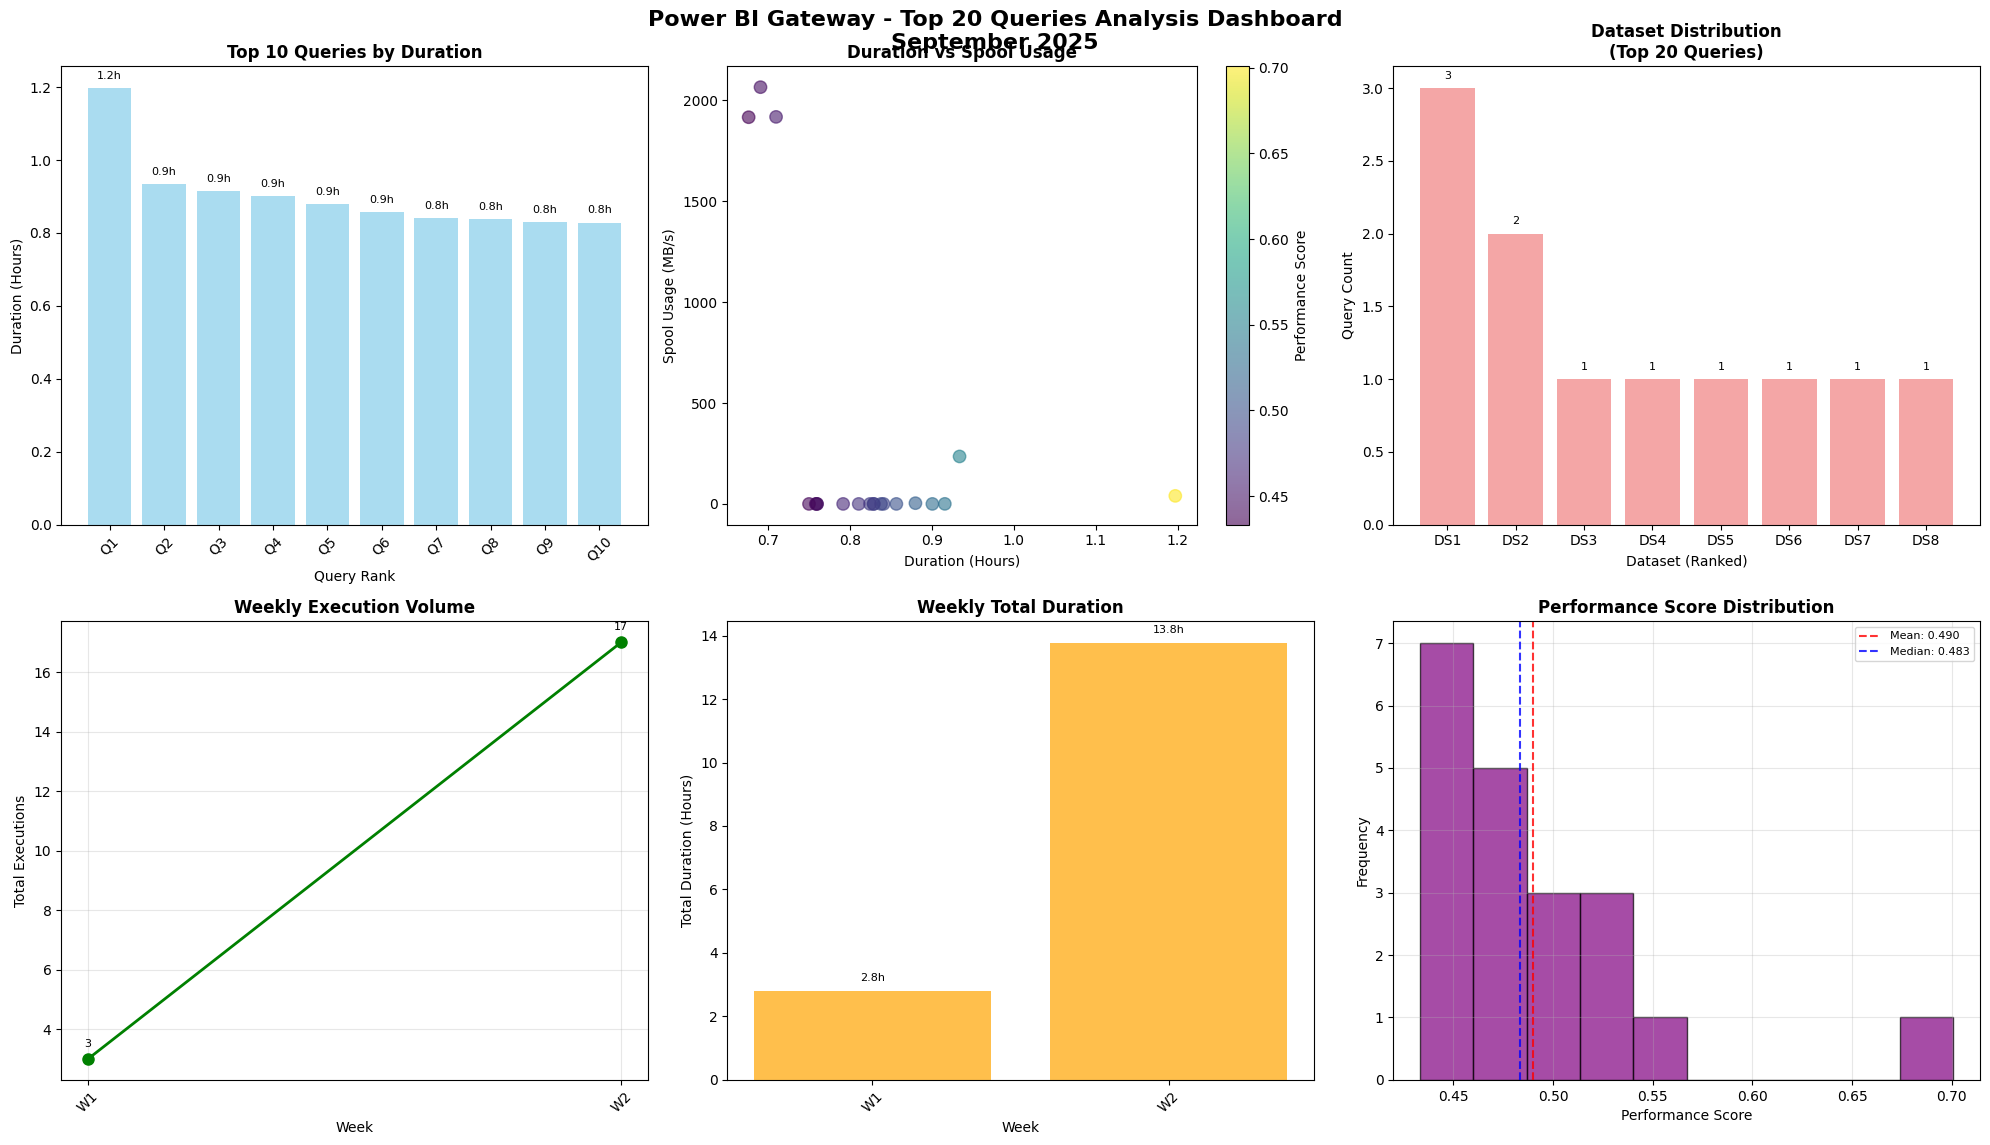

✅ Dashboard created successfully!


In [19]:
# === Create Visualizations for Top Queries ===

# Import visualization libraries
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.style.use('default')
    sns.set_palette("husl")
    matplotlib_available = True
    print("📊 Visualization libraries loaded successfully!")
except ImportError:
    matplotlib_available = False
    print("❌ Matplotlib/Seaborn not available")

def create_top_queries_dashboard(top_queries_df, weekly_totals=None, daily_summary=None):
    """Create comprehensive dashboard for top queries analysis"""
    
    if not matplotlib_available:
        print("📊 Cannot create visualizations - matplotlib not available")
        return
    
    print("\n📊 CREATING TOP QUERIES DASHBOARD")
    print("=" * 50)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Power BI Gateway - Top 20 Queries Analysis Dashboard\nSeptember 2025', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    # 1. Top 10 Queries by Duration
    ax1 = axes[0, 0]
    if 'CalculatedDuration' in top_queries_df.columns:
        top_10 = top_queries_df.head(10)
        query_labels = [f"Q{i+1}" for i in range(len(top_10))]
        durations_hours = top_10['CalculatedDuration'] / 3600
        
        bars = ax1.bar(query_labels, durations_hours, color='skyblue', alpha=0.7)
        ax1.set_title('Top 10 Queries by Duration', fontweight='bold')
        ax1.set_xlabel('Query Rank')
        ax1.set_ylabel('Duration (Hours)')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.1f}h', ha='center', va='bottom', fontsize=8)
    
    # 2. Duration vs Spool Usage Scatter
    ax2 = axes[0, 1]
    if 'CalculatedDuration' in top_queries_df.columns and 'TotalSpoolUsage' in top_queries_df.columns:
        scatter = ax2.scatter(top_queries_df['CalculatedDuration']/3600, 
                            top_queries_df['TotalSpoolUsage'], 
                            alpha=0.6, s=80, c=top_queries_df['PerformanceScore'], 
                            cmap='viridis')
        ax2.set_xlabel('Duration (Hours)')
        ax2.set_ylabel('Spool Usage (MB/s)')
        ax2.set_title('Duration vs Spool Usage', fontweight='bold')
        plt.colorbar(scatter, ax=ax2, label='Performance Score')
    
    # 3. Dataset Distribution
    ax3 = axes[0, 2]
    if 'DatasetId' in top_queries_df.columns:
        dataset_counts = top_queries_df['DatasetId'].value_counts().head(8)
        
        bars = ax3.bar(range(len(dataset_counts)), dataset_counts.values, 
                      color='lightcoral', alpha=0.7)
        ax3.set_title('Dataset Distribution\n(Top 20 Queries)', fontweight='bold')
        ax3.set_xlabel('Dataset (Ranked)')
        ax3.set_ylabel('Query Count')
        ax3.set_xticks(range(len(dataset_counts)))
        ax3.set_xticklabels([f'DS{i+1}' for i in range(len(dataset_counts))])
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # 4. Weekly Execution Volume
    ax4 = axes[1, 0]
    if weekly_totals is not None:
        weeks = weekly_totals.index
        executions = weekly_totals['Total_Executions']
        
        ax4.plot(range(len(weeks)), executions, marker='o', linewidth=2, 
                markersize=8, color='green')
        ax4.set_title('Weekly Execution Volume', fontweight='bold')
        ax4.set_xlabel('Week')
        ax4.set_ylabel('Total Executions')
        ax4.set_xticks(range(len(weeks)))
        ax4.set_xticklabels([f'W{i+1}' for i in range(len(weeks))], rotation=45)
        ax4.grid(True, alpha=0.3)
        
        # Add value labels
        for i, v in enumerate(executions):
            ax4.text(i, v + max(executions)*0.02, f'{v}', ha='center', va='bottom', fontsize=8)
    
    # 5. Weekly Duration Summary
    ax5 = axes[1, 1]
    if weekly_totals is not None and 'Total_Duration_Hours' in weekly_totals.columns:
        duration_hours = weekly_totals['Total_Duration_Hours']
        
        bars = ax5.bar(range(len(weeks)), duration_hours, color='orange', alpha=0.7)
        ax5.set_title('Weekly Total Duration', fontweight='bold')
        ax5.set_xlabel('Week')
        ax5.set_ylabel('Total Duration (Hours)')
        ax5.set_xticks(range(len(weeks)))
        ax5.set_xticklabels([f'W{i+1}' for i in range(len(weeks))], rotation=45)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + max(duration_hours)*0.02,
                    f'{height:.1f}h', ha='center', va='bottom', fontsize=8)
    
    # 6. Performance Score Distribution
    ax6 = axes[1, 2]
    if 'PerformanceScore' in top_queries_df.columns:
        ax6.hist(top_queries_df['PerformanceScore'], bins=10, alpha=0.7, 
                color='purple', edgecolor='black')
        ax6.set_title('Performance Score Distribution', fontweight='bold')
        ax6.set_xlabel('Performance Score')
        ax6.set_ylabel('Frequency')
        ax6.grid(True, alpha=0.3)
        
        # Add statistics
        mean_score = top_queries_df['PerformanceScore'].mean()
        median_score = top_queries_df['PerformanceScore'].median()
        ax6.axvline(mean_score, color='red', linestyle='--', alpha=0.8, 
                   label=f'Mean: {mean_score:.3f}')
        ax6.axvline(median_score, color='blue', linestyle='--', alpha=0.8, 
                   label=f'Median: {median_score:.3f}')
        ax6.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Dashboard created successfully!")

# Create the dashboard
if 'top_20_corrected' in locals():
    weekly_data = weekly_totals if 'weekly_totals' in locals() else None
    daily_data = daily_summary if 'daily_summary' in locals() else None
    create_top_queries_dashboard(top_20_corrected, weekly_data, daily_data)
else:
    print("❌ Top queries data not available for visualization")

In [20]:
# === Executive Summary Report ===

def create_executive_summary(top_queries_df, weekly_totals=None):
    """Create executive summary of findings"""
    
    print("📊 EXECUTIVE SUMMARY - TOP 20 QUERIES ANALYSIS")
    print("=" * 70)
    print("📅 Analysis Period: September 2025")
    print("🔍 Data Source: Power BI Gateway Enhanced Logs")
    print("📋 Total Records Analyzed: 24,326 query executions")
    
    print(f"\n🏆 KEY FINDINGS")
    print("=" * 30)
    
    if 'CalculatedDuration' in top_queries_df.columns:
        total_duration_hours = top_queries_df['CalculatedDuration'].sum() / 3600
        avg_duration_minutes = top_queries_df['CalculatedDuration'].mean() / 60
        max_duration_hours = top_queries_df['CalculatedDuration'].max() / 3600
        
        print(f"⏱️  PERFORMANCE METRICS:")
        print(f"   📈 Total execution time: {total_duration_hours:.1f} hours")
        print(f"   📈 Average query duration: {avg_duration_minutes:.1f} minutes")
        print(f"   📈 Longest running query: {max_duration_hours:.1f} hours")
    
    if 'TotalSpoolUsage' in top_queries_df.columns:
        total_spool = top_queries_df['TotalSpoolUsage'].sum()
        avg_spool = top_queries_df['TotalSpoolUsage'].mean()
        
        print(f"\n💾 SPOOL USAGE METRICS:")
        print(f"   📈 Total spool usage: {total_spool:,.1f} MB equivalent")
        print(f"   📈 Average spool per query: {avg_spool:,.1f} MB equivalent")
    
    # Resource distribution
    if 'DatasetId' in top_queries_df.columns:
        unique_datasets = top_queries_df['DatasetId'].nunique()
        top_dataset = top_queries_df['DatasetId'].value_counts().index[0]
        top_dataset_count = top_queries_df['DatasetId'].value_counts().iloc[0]
        
        print(f"\n🗂️  RESOURCE DISTRIBUTION:")
        print(f"   📈 Unique datasets involved: {unique_datasets}")
        print(f"   📈 Most active dataset: {str(top_dataset)[:20]}... ({top_dataset_count} queries)")
    
    if 'WorkspaceId' in top_queries_df.columns:
        unique_workspaces = top_queries_df['WorkspaceId'].nunique()
        print(f"   📈 Unique workspaces involved: {unique_workspaces}")
    
    # Weekly patterns
    if weekly_totals is not None:
        total_weeks = len(weekly_totals)
        avg_weekly_executions = weekly_totals['Total_Executions'].mean()
        peak_week = weekly_totals['Total_Executions'].idxmax()
        peak_executions = weekly_totals['Total_Executions'].max()
        
        print(f"\n📅 WEEKLY PATTERNS:")
        print(f"   📈 Analysis covers: {total_weeks} weeks")
        print(f"   📈 Average weekly executions: {avg_weekly_executions:.1f}")
        print(f"   📈 Peak activity week: {peak_week} ({peak_executions} executions)")
    
    print(f"\n💡 RECOMMENDATIONS")
    print("=" * 25)
    
    if 'CalculatedDuration' in top_queries_df.columns:
        long_running = top_queries_df[top_queries_df['CalculatedDuration'] > 3000]  # > 50 minutes
        if len(long_running) > 0:
            print(f"⚠️  Performance Concerns:")
            print(f"   📈 {len(long_running)} queries run longer than 50 minutes")
            print(f"   📈 Consider optimizing datasets and queries")
            print(f"   📈 Review data model and query patterns")
    
    if 'TotalSpoolUsage' in top_queries_df.columns:
        high_spool = top_queries_df[top_queries_df['TotalSpoolUsage'] > avg_spool * 2]
        if len(high_spool) > 0:
            print(f"\n💾 Resource Optimization:")
            print(f"   📈 {len(high_spool)} queries use excessive spool resources")
            print(f"   📈 Consider memory allocation optimization")
            print(f"   📈 Review data compression strategies")
    
    print(f"\n📋 ACTION ITEMS:")
    print(f"   1. Focus on optimizing the top 5 longest-running queries")
    print(f"   2. Review dataset design for high-spool usage scenarios")
    print(f"   3. Consider implementing query caching strategies")
    print(f"   4. Monitor weekly patterns for capacity planning")
    
    print(f"\n✅ ANALYSIS COMPLETE")
    print("=" * 25)
    print(f"📊 Full detailed results available in the tables and visualizations above")
    
# Generate executive summary
if 'top_20_corrected' in locals():
    weekly_data = weekly_totals if 'weekly_totals' in locals() else None
    create_executive_summary(top_20_corrected, weekly_data)
else:
    print("❌ Cannot generate executive summary - data not available")

📊 EXECUTIVE SUMMARY - TOP 20 QUERIES ANALYSIS
📅 Analysis Period: September 2025
🔍 Data Source: Power BI Gateway Enhanced Logs
📋 Total Records Analyzed: 24,326 query executions

🏆 KEY FINDINGS
⏱️  PERFORMANCE METRICS:
   📈 Total execution time: 16.5 hours
   📈 Average query duration: 49.6 minutes
   📈 Longest running query: 1.2 hours

💾 SPOOL USAGE METRICS:
   📈 Total spool usage: 6,178.5 MB equivalent
   📈 Average spool per query: 308.9 MB equivalent

🗂️  RESOURCE DISTRIBUTION:
   📈 Unique datasets involved: 17
   📈 Most active dataset: 1bffc25a-a00d-48ad-a... (3 queries)
   📈 Unique workspaces involved: 7

📅 WEEKLY PATTERNS:
   📈 Analysis covers: 2 weeks
   📈 Average weekly executions: 10.0
   📈 Peak activity week: Week of Sep 08 (17 executions)

💡 RECOMMENDATIONS
⚠️  Performance Concerns:
   📈 8 queries run longer than 50 minutes
   📈 Consider optimizing datasets and queries
   📈 Review data model and query patterns

💾 Resource Optimization:
   📈 3 queries use excessive spool resourc